In [1]:
import scanpy as sc
import numpy as np
from ndreamer import NDreamer

# The estimated ITE for the real data

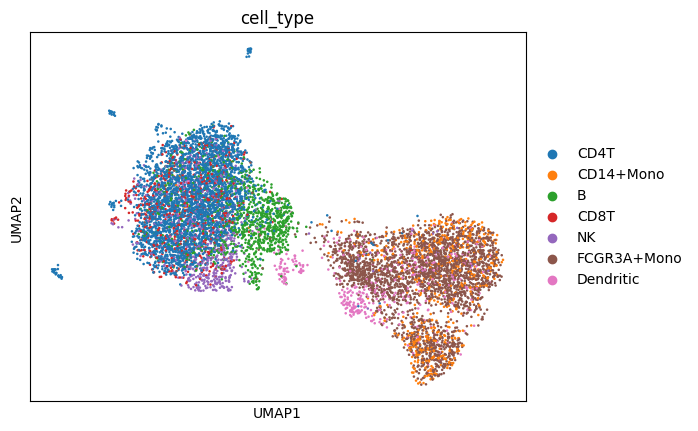

In [2]:
ITE=sc.read_h5ad("./PBMC/b-0--c-1__ITE.h5ad")

sc.pp.pca(ITE)
sc.pp.neighbors(ITE)
sc.tl.umap(ITE)
sc.pl.umap(ITE, color=['cell_type'], ncols=1)

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'
condition ['control' 'stimulated']
cell_type ['B' 'CD14+Mono' 'CD4T' 'CD8T' 'Dendritic' 'FCGR3A+Mono' 'NK']
  (0, 6)	3.206646203994751
  (0, 7)	0.9476891756057739
  (1, 6)	3.3140597343444824
  (2, 6)	2.344876527786255
  (3, 6)	2.292093276977539
  (4, 6)	2.430964708328247
  (5, 3)	0.29651933908462524
  (5, 6)	3.045463800430298
  (6, 6)	2.0396549701690674
  (7, 6)	3.98563814163208
  (8, 5)	0.5871325731277466
  (8, 6)	4.5311431884765625
  (9, 6)	2.4054837226867676


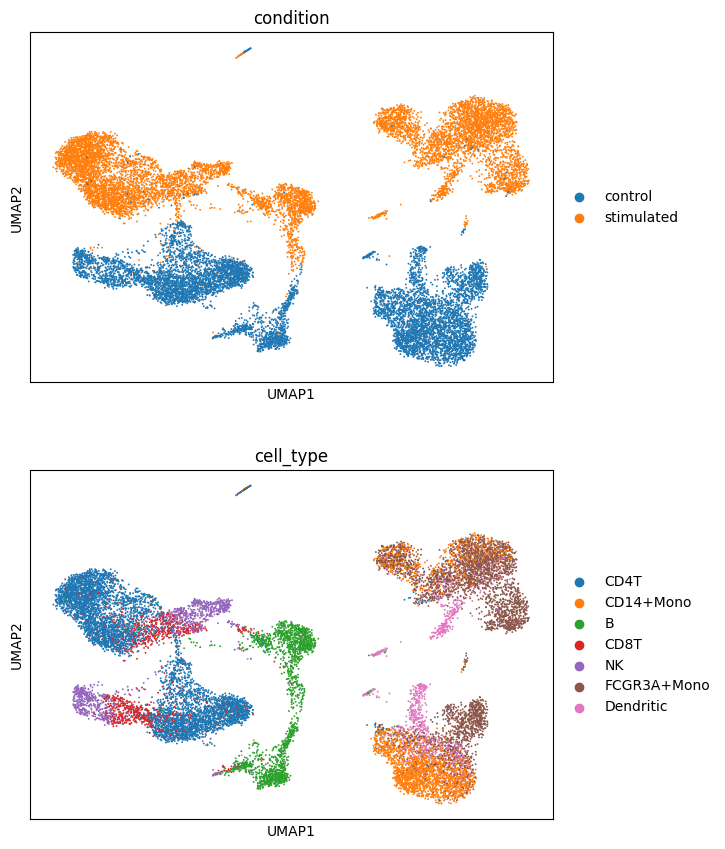

In [3]:
adata = sc.read_h5ad('../data/PBMC.h5ad')
print(adata)
print('condition',np.unique(adata.obs['condition']))
#print('batch',np.unique(adata.obs['batch']))
print('cell_type',np.unique(adata.obs['cell_type']))
print(adata.X[:10,:10])
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["condition",'cell_type'],ncols=1)

# Now, if we random permute the condition label

['control' 'stimulated']


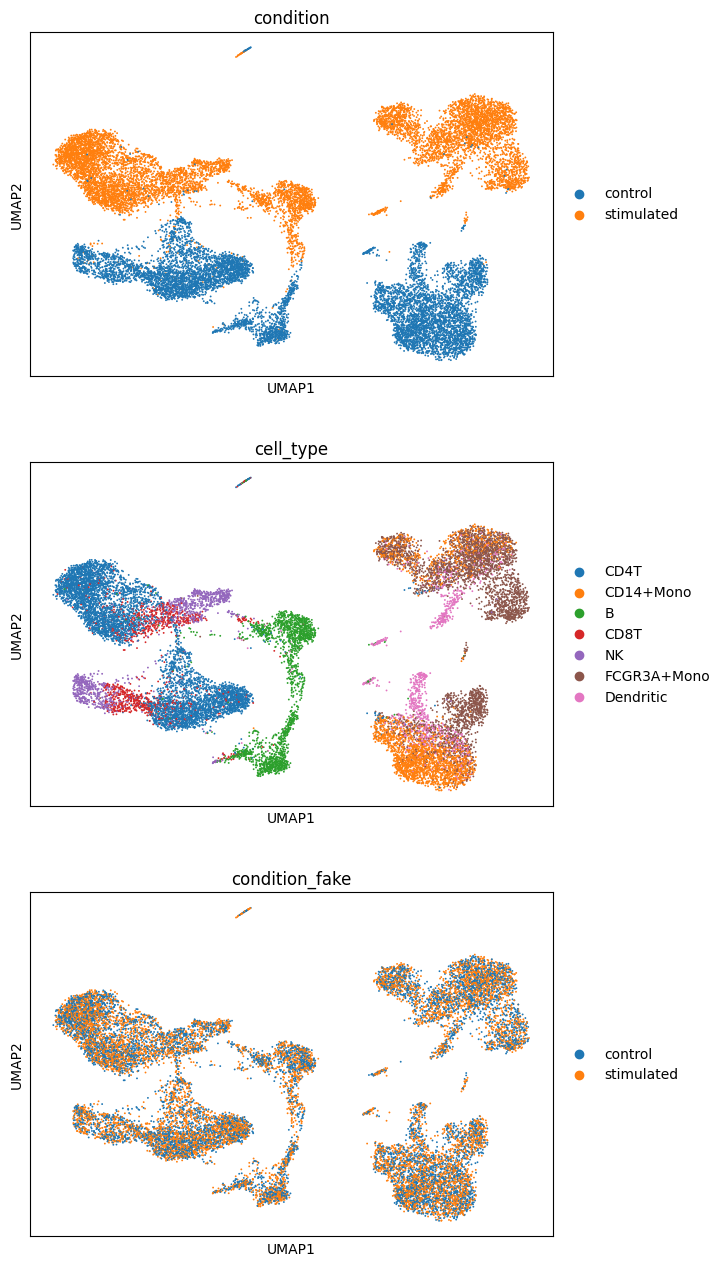

In [4]:
adata.obs["condition_fake"]=np.random.permutation(adata.obs["condition"].copy())#condition_fake
print(np.unique(adata.obs["condition_fake"]))
sc.pl.umap(adata, color=["condition",'cell_type',"condition_fake"],ncols=1)

In [5]:
model = NDreamer(adata, condition_key="condition_fake", contorl_name='control', num_hvg=2000, require_batch=False,
                        batch_key=None,
                        resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=100, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./PBMC_fake_permute/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./PBMC_fake_permute/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[condition_fake] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'control': 0, 'stimulated': 1}
Condition mapping to adata.obs['batch']: {'batch': {0: 0}}
Unique batch mapping: {0: 0}


Calculating the clusters
Unique groups: ['0_control' '0_stimulated']


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:38: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  clustering_function(adata, resolution=resolution1)


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:100: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = clustered_adatas[0].concatenate(*clustered_adatas[1:], batch_key="batch_condition",


Finished clustering
Data preprocessing done
Remaining number of cells: 16893
Too few epoches (steps, if rigorously speaking). Changing epoch to 148 to adjust for number of cells
Require batch: False
Batch name to number mapping (may be used for search for saved adata):
 {'batch': {0: 0}}
Condition name to number mapping (may be used for search for saved adata):
 {'control': 0, 'stimulated': 1}
Preprocessing time: 19.39930 seconds


Overall Progress:   0%|          | 0/148 [00:00<?, ?it/s]

Epoch: 1/148 | All Loss: 81.1264 | Neighborhood Loss: 15.3555 | Triplet Loss: 49.5453 | Reconstruction Loss: 15.2733 | Independent Loss: 10.8384 | KL Loss: 0.3772 | Commitment Loss: 0.5959 | Dependent Loss: -10.8592


Epoch: 2/148 | All Loss: 39.5874 | Neighborhood Loss: 15.8248 | Triplet Loss: 17.9623 | Reconstruction Loss: 8.4697 | Independent Loss: 8.3947 | KL Loss: 0.4038 | Commitment Loss: 0.5905 | Dependent Loss: -12.0584


Epoch: 3/148 | All Loss: 36.7385 | Neighborhood Loss: 15.4512 | Triplet Loss: 19.3232 | Reconstruction Loss: 6.8384 | Independent Loss: 6.6620 | KL Loss: 0.4440 | Commitment Loss: 0.5886 | Dependent Loss: -12.5688


Epoch: 4/148 | All Loss: 27.8043 | Neighborhood Loss: 15.0935 | Triplet Loss: 13.0647 | Reconstruction Loss: 6.7186 | Independent Loss: 4.9361 | KL Loss: 0.4357 | Commitment Loss: 0.5887 | Dependent Loss: -13.0329


Epoch: 5/148 | All Loss: 25.3026 | Neighborhood Loss: 14.2247 | Triplet Loss: 12.3202 | Reconstruction Loss: 6.6555 | Independent Loss: 4.2554 | KL Loss: 0.4124 | Commitment Loss: 0.5852 | Dependent Loss: -13.1509


Epoch: 6/148 | All Loss: 21.2497 | Neighborhood Loss: 14.3461 | Triplet Loss: 9.0403 | Reconstruction Loss: 6.5220 | Independent Loss: 3.9332 | KL Loss: 0.3843 | Commitment Loss: 0.5765 | Dependent Loss: -13.5528


Epoch: 7/148 | All Loss: 17.4674 | Neighborhood Loss: 12.9924 | Triplet Loss: 7.0130 | Reconstruction Loss: 6.4481 | Independent Loss: 3.7778 | KL Loss: 0.3534 | Commitment Loss: 0.5733 | Dependent Loss: -13.6905


Epoch: 8/148 | All Loss: 14.9699 | Neighborhood Loss: 12.0763 | Triplet Loss: 6.0548 | Reconstruction Loss: 6.3774 | Independent Loss: 3.2532 | KL Loss: 0.3240 | Commitment Loss: 0.5722 | Dependent Loss: -13.6879


Epoch: 9/148 | All Loss: 13.3629 | Neighborhood Loss: 11.8471 | Triplet Loss: 5.3091 | Reconstruction Loss: 6.0988 | Independent Loss: 3.0948 | KL Loss: 0.2999 | Commitment Loss: 0.5771 | Dependent Loss: -13.8638


Epoch: 10/148 | All Loss: 12.7158 | Neighborhood Loss: 10.7686 | Triplet Loss: 6.1910 | Reconstruction Loss: 5.9603 | Independent Loss: 2.7248 | KL Loss: 0.2762 | Commitment Loss: 0.5769 | Dependent Loss: -13.7820


Epoch: 11/148 | All Loss: 11.5019 | Neighborhood Loss: 10.3303 | Triplet Loss: 5.4368 | Reconstruction Loss: 5.8200 | Independent Loss: 3.0448 | KL Loss: 0.2563 | Commitment Loss: 0.5770 | Dependent Loss: -13.9634


Epoch: 12/148 | All Loss: 9.4384 | Neighborhood Loss: 10.0413 | Triplet Loss: 4.4426 | Reconstruction Loss: 5.7952 | Independent Loss: 2.2312 | KL Loss: 0.2378 | Commitment Loss: 0.5755 | Dependent Loss: -13.8851


Epoch: 13/148 | All Loss: 11.1931 | Neighborhood Loss: 10.7364 | Triplet Loss: 5.3795 | Reconstruction Loss: 5.7082 | Independent Loss: 2.4874 | KL Loss: 0.2245 | Commitment Loss: 0.5738 | Dependent Loss: -13.9166


Epoch: 14/148 | All Loss: 9.0951 | Neighborhood Loss: 10.4068 | Triplet Loss: 4.1532 | Reconstruction Loss: 5.6339 | Independent Loss: 2.2949 | KL Loss: 0.2147 | Commitment Loss: 0.5729 | Dependent Loss: -14.1813


Resetting 744 unused embeddings.
Resetting 785 unused embeddings.
Resetting 719 unused embeddings.


Resetting 791 unused embeddings.
Resetting 777 unused embeddings.
Resetting 777 unused embeddings.


Resetting 750 unused embeddings.
Resetting 769 unused embeddings.
Resetting 767 unused embeddings.


Resetting 778 unused embeddings.
Resetting 808 unused embeddings.
Resetting 765 unused embeddings.


Resetting 797 unused embeddings.
Resetting 770 unused embeddings.
Resetting 725 unused embeddings.


Resetting 741 unused embeddings.
Resetting 779 unused embeddings.
Resetting 735 unused embeddings.


Resetting 787 unused embeddings.
Resetting 711 unused embeddings.
Resetting 723 unused embeddings.


Resetting 747 unused embeddings.
Resetting 755 unused embeddings.
Resetting 781 unused embeddings.


Resetting 766 unused embeddings.
Resetting 743 unused embeddings.
Resetting 742 unused embeddings.


Resetting 773 unused embeddings.
Resetting 732 unused embeddings.
Resetting 728 unused embeddings.


Resetting 770 unused embeddings.
Resetting 739 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 14
Epoch: 15/148 | All Loss: 3.6284 | Neighborhood Loss: 4.9395 | Triplet Loss: 1.4864 | Reconstruction Loss: 2.7909 | Independent Loss: 0.9786 | KL Loss: 0.1030 | Commitment Loss: 0.2844 | Dependent Loss: -6.9544


Epoch: 16/148 | All Loss: 12.9842 | Neighborhood Loss: 9.9711 | Triplet Loss: 7.3491 | Reconstruction Loss: 5.6825 | Independent Loss: 0.8284 | KL Loss: 0.1806 | Commitment Loss: 0.2695 | Dependent Loss: -11.2969


Epoch: 17/148 | All Loss: 10.7218 | Neighborhood Loss: 10.8019 | Triplet Loss: 3.8604 | Reconstruction Loss: 5.5717 | Independent Loss: 1.4965 | KL Loss: 0.1703 | Commitment Loss: 0.2666 | Dependent Loss: -11.4456


Epoch: 18/148 | All Loss: 9.4480 | Neighborhood Loss: 9.8858 | Triplet Loss: 3.7715 | Reconstruction Loss: 5.5252 | Independent Loss: 1.2086 | KL Loss: 0.1606 | Commitment Loss: 0.2685 | Dependent Loss: -11.3721


Epoch: 19/148 | All Loss: 9.7263 | Neighborhood Loss: 9.3491 | Triplet Loss: 4.9087 | Reconstruction Loss: 5.4757 | Independent Loss: 1.0065 | KL Loss: 0.1524 | Commitment Loss: 0.2716 | Dependent Loss: -11.4378


Epoch: 20/148 | All Loss: 10.1065 | Neighborhood Loss: 9.6783 | Triplet Loss: 4.8403 | Reconstruction Loss: 5.5846 | Independent Loss: 1.0142 | KL Loss: 0.1452 | Commitment Loss: 0.2691 | Dependent Loss: -11.4252


Epoch: 21/148 | All Loss: 9.5488 | Neighborhood Loss: 8.8589 | Triplet Loss: 5.2578 | Reconstruction Loss: 5.6023 | Independent Loss: 1.0179 | KL Loss: 0.1413 | Commitment Loss: 0.2671 | Dependent Loss: -11.5963


Epoch: 22/148 | All Loss: 7.2672 | Neighborhood Loss: 8.7627 | Triplet Loss: 3.0132 | Reconstruction Loss: 5.5782 | Independent Loss: 0.9827 | KL Loss: 0.1390 | Commitment Loss: 0.2719 | Dependent Loss: -11.4806


Epoch: 23/148 | All Loss: 8.5515 | Neighborhood Loss: 8.3813 | Triplet Loss: 4.3374 | Reconstruction Loss: 5.5126 | Independent Loss: 1.5003 | KL Loss: 0.1370 | Commitment Loss: 0.2768 | Dependent Loss: -11.5939


Epoch: 24/148 | All Loss: 7.8682 | Neighborhood Loss: 8.5371 | Triplet Loss: 4.0224 | Reconstruction Loss: 5.4801 | Independent Loss: 0.9135 | KL Loss: 0.1317 | Commitment Loss: 0.2771 | Dependent Loss: -11.4936


Epoch: 25/148 | All Loss: 8.5913 | Neighborhood Loss: 8.2945 | Triplet Loss: 4.7930 | Reconstruction Loss: 5.4766 | Independent Loss: 1.2407 | KL Loss: 0.1247 | Commitment Loss: 0.2761 | Dependent Loss: -11.6144


Epoch: 26/148 | All Loss: 7.2923 | Neighborhood Loss: 7.6930 | Triplet Loss: 4.0088 | Reconstruction Loss: 5.5071 | Independent Loss: 1.2989 | KL Loss: 0.1206 | Commitment Loss: 0.2773 | Dependent Loss: -11.6134


Epoch: 27/148 | All Loss: 7.5182 | Neighborhood Loss: 8.1826 | Triplet Loss: 3.9026 | Reconstruction Loss: 5.4415 | Independent Loss: 1.1749 | KL Loss: 0.1188 | Commitment Loss: 0.2833 | Dependent Loss: -11.5855


Epoch: 28/148 | All Loss: 7.9613 | Neighborhood Loss: 7.7624 | Triplet Loss: 4.7947 | Reconstruction Loss: 5.4677 | Independent Loss: 1.1197 | KL Loss: 0.1154 | Commitment Loss: 0.2800 | Dependent Loss: -11.5785


Epoch: 29/148 | All Loss: 7.1282 | Neighborhood Loss: 8.1900 | Triplet Loss: 3.7481 | Reconstruction Loss: 5.5220 | Independent Loss: 0.8272 | KL Loss: 0.1111 | Commitment Loss: 0.2784 | Dependent Loss: -11.5486


Resetting 720 unused embeddings.
Resetting 742 unused embeddings.
Resetting 722 unused embeddings.


Resetting 739 unused embeddings.
Resetting 738 unused embeddings.
Resetting 707 unused embeddings.


Resetting 711 unused embeddings.
Resetting 729 unused embeddings.
Resetting 709 unused embeddings.


Resetting 760 unused embeddings.
Resetting 777 unused embeddings.
Resetting 730 unused embeddings.


Resetting 732 unused embeddings.
Resetting 755 unused embeddings.
Resetting 741 unused embeddings.


Resetting 714 unused embeddings.
Resetting 744 unused embeddings.
Resetting 694 unused embeddings.


Resetting 723 unused embeddings.
Resetting 685 unused embeddings.
Resetting 686 unused embeddings.


Resetting 702 unused embeddings.
Resetting 748 unused embeddings.
Resetting 718 unused embeddings.


Resetting 757 unused embeddings.
Resetting 704 unused embeddings.
Resetting 707 unused embeddings.


Resetting 722 unused embeddings.
Resetting 710 unused embeddings.
Resetting 731 unused embeddings.


Resetting 724 unused embeddings.
Resetting 732 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 29
Epoch: 30/148 | All Loss: 4.1362 | Neighborhood Loss: 4.5519 | Triplet Loss: 2.0347 | Reconstruction Loss: 2.7363 | Independent Loss: 0.4592 | KL Loss: 0.0553 | Commitment Loss: 0.1432 | Dependent Loss: -5.8445


Epoch: 31/148 | All Loss: 6.6468 | Neighborhood Loss: 8.0750 | Triplet Loss: 3.8410 | Reconstruction Loss: 5.4368 | Independent Loss: 0.9606 | KL Loss: 0.1071 | Commitment Loss: 0.2096 | Dependent Loss: -11.9834


Epoch: 32/148 | All Loss: 6.6690 | Neighborhood Loss: 7.5303 | Triplet Loss: 4.3742 | Reconstruction Loss: 5.3674 | Independent Loss: 0.9740 | KL Loss: 0.1036 | Commitment Loss: 0.2093 | Dependent Loss: -11.8899


Epoch: 33/148 | All Loss: 5.8878 | Neighborhood Loss: 7.9730 | Triplet Loss: 3.3943 | Reconstruction Loss: 5.4424 | Independent Loss: 0.7390 | KL Loss: 0.0985 | Commitment Loss: 0.2094 | Dependent Loss: -11.9687


Epoch: 34/148 | All Loss: 4.4843 | Neighborhood Loss: 6.7374 | Triplet Loss: 3.1375 | Reconstruction Loss: 5.4285 | Independent Loss: 0.9753 | KL Loss: 0.0932 | Commitment Loss: 0.2070 | Dependent Loss: -12.0947


Epoch: 35/148 | All Loss: 5.7352 | Neighborhood Loss: 7.0484 | Triplet Loss: 3.8171 | Reconstruction Loss: 5.4420 | Independent Loss: 1.0588 | KL Loss: 0.0898 | Commitment Loss: 0.2108 | Dependent Loss: -11.9316


Epoch: 36/148 | All Loss: 5.8893 | Neighborhood Loss: 7.4740 | Triplet Loss: 3.5704 | Reconstruction Loss: 5.3723 | Independent Loss: 1.2129 | KL Loss: 0.0893 | Commitment Loss: 0.2106 | Dependent Loss: -12.0402


Epoch: 37/148 | All Loss: 5.2765 | Neighborhood Loss: 7.4123 | Triplet Loss: 3.4234 | Reconstruction Loss: 5.2693 | Independent Loss: 0.9855 | KL Loss: 0.0891 | Commitment Loss: 0.2128 | Dependent Loss: -12.1160


Epoch: 38/148 | All Loss: 5.2774 | Neighborhood Loss: 7.2047 | Triplet Loss: 3.6165 | Reconstruction Loss: 5.3327 | Independent Loss: 0.9610 | KL Loss: 0.0891 | Commitment Loss: 0.2141 | Dependent Loss: -12.1407


Epoch: 39/148 | All Loss: 6.5690 | Neighborhood Loss: 7.6287 | Triplet Loss: 4.1272 | Reconstruction Loss: 5.4100 | Independent Loss: 1.0971 | KL Loss: 0.0897 | Commitment Loss: 0.2172 | Dependent Loss: -12.0010


Epoch: 40/148 | All Loss: 6.5526 | Neighborhood Loss: 7.7374 | Triplet Loss: 4.1535 | Reconstruction Loss: 5.3120 | Independent Loss: 1.2625 | KL Loss: 0.0894 | Commitment Loss: 0.2149 | Dependent Loss: -12.2170


Epoch: 41/148 | All Loss: 4.5497 | Neighborhood Loss: 7.1495 | Triplet Loss: 2.7802 | Reconstruction Loss: 5.3545 | Independent Loss: 1.1501 | KL Loss: 0.0869 | Commitment Loss: 0.2182 | Dependent Loss: -12.1896


Epoch: 42/148 | All Loss: 4.9625 | Neighborhood Loss: 7.6086 | Triplet Loss: 2.5838 | Reconstruction Loss: 5.4042 | Independent Loss: 1.2111 | KL Loss: 0.0846 | Commitment Loss: 0.2185 | Dependent Loss: -12.1484


Epoch: 43/148 | All Loss: 3.7163 | Neighborhood Loss: 7.1625 | Triplet Loss: 2.3375 | Reconstruction Loss: 5.3293 | Independent Loss: 0.7819 | KL Loss: 0.0851 | Commitment Loss: 0.2214 | Dependent Loss: -12.2012


Epoch: 44/148 | All Loss: 5.7242 | Neighborhood Loss: 7.9905 | Triplet Loss: 3.1459 | Reconstruction Loss: 5.3116 | Independent Loss: 1.2001 | KL Loss: 0.0870 | Commitment Loss: 0.2253 | Dependent Loss: -12.2363


Resetting 694 unused embeddings.
Resetting 722 unused embeddings.
Resetting 693 unused embeddings.


Resetting 727 unused embeddings.
Resetting 706 unused embeddings.
Resetting 671 unused embeddings.


Resetting 694 unused embeddings.
Resetting 708 unused embeddings.
Resetting 694 unused embeddings.


Resetting 728 unused embeddings.
Resetting 714 unused embeddings.
Resetting 703 unused embeddings.


Resetting 705 unused embeddings.
Resetting 713 unused embeddings.
Resetting 710 unused embeddings.
Resetting 675 unused embeddings.


Resetting 731 unused embeddings.
Resetting 671 unused embeddings.
Resetting 698 unused embeddings.


Resetting 664 unused embeddings.
Resetting 665 unused embeddings.
Resetting 683 unused embeddings.


Resetting 709 unused embeddings.
Resetting 697 unused embeddings.


Resetting 689 unused embeddings.
Resetting 661 unused embeddings.
Resetting 679 unused embeddings.


Resetting 701 unused embeddings.
Resetting 686 unused embeddings.
Resetting 708 unused embeddings.


Resetting 663 unused embeddings.
Resetting 678 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 44
Epoch: 45/148 | All Loss: 2.8324 | Neighborhood Loss: 3.5999 | Triplet Loss: 1.9752 | Reconstruction Loss: 2.6668 | Independent Loss: 0.4720 | KL Loss: 0.0435 | Commitment Loss: 0.1127 | Dependent Loss: -6.0378


Epoch: 46/148 | All Loss: 4.3734 | Neighborhood Loss: 7.3255 | Triplet Loss: 2.6955 | Reconstruction Loss: 5.3989 | Independent Loss: 1.0452 | KL Loss: 0.0879 | Commitment Loss: 0.2058 | Dependent Loss: -12.3856


Epoch: 47/148 | All Loss: 4.6968 | Neighborhood Loss: 7.6071 | Triplet Loss: 2.8320 | Reconstruction Loss: 5.3084 | Independent Loss: 1.1174 | KL Loss: 0.0868 | Commitment Loss: 0.2080 | Dependent Loss: -12.4628


Epoch: 48/148 | All Loss: 4.8488 | Neighborhood Loss: 7.0712 | Triplet Loss: 3.2660 | Reconstruction Loss: 5.3137 | Independent Loss: 1.4220 | KL Loss: 0.0846 | Commitment Loss: 0.2071 | Dependent Loss: -12.5159


Epoch: 49/148 | All Loss: 5.1873 | Neighborhood Loss: 7.2612 | Triplet Loss: 3.5170 | Reconstruction Loss: 5.3880 | Independent Loss: 1.1956 | KL Loss: 0.0836 | Commitment Loss: 0.2105 | Dependent Loss: -12.4686


Epoch: 50/148 | All Loss: 4.4885 | Neighborhood Loss: 6.9567 | Triplet Loss: 2.8649 | Reconstruction Loss: 5.3133 | Independent Loss: 1.4420 | KL Loss: 0.0835 | Commitment Loss: 0.2097 | Dependent Loss: -12.3816


Epoch: 51/148 | All Loss: 3.4179 | Neighborhood Loss: 7.0962 | Triplet Loss: 2.2719 | Reconstruction Loss: 5.3779 | Independent Loss: 0.9370 | KL Loss: 0.0821 | Commitment Loss: 0.2102 | Dependent Loss: -12.5573


Epoch: 52/148 | All Loss: 4.6203 | Neighborhood Loss: 7.2083 | Triplet Loss: 2.8777 | Reconstruction Loss: 5.2927 | Independent Loss: 1.5154 | KL Loss: 0.0831 | Commitment Loss: 0.2099 | Dependent Loss: -12.5667


Epoch: 53/148 | All Loss: 4.0660 | Neighborhood Loss: 6.7647 | Triplet Loss: 3.2159 | Reconstruction Loss: 5.4061 | Independent Loss: 1.0932 | KL Loss: 0.0829 | Commitment Loss: 0.2124 | Dependent Loss: -12.7092


Epoch: 54/148 | All Loss: 3.8849 | Neighborhood Loss: 7.4203 | Triplet Loss: 2.4378 | Reconstruction Loss: 5.3149 | Independent Loss: 1.0738 | KL Loss: 0.0825 | Commitment Loss: 0.2109 | Dependent Loss: -12.6553


Epoch: 55/148 | All Loss: 3.2301 | Neighborhood Loss: 7.3874 | Triplet Loss: 1.7736 | Reconstruction Loss: 5.3566 | Independent Loss: 1.1790 | KL Loss: 0.0816 | Commitment Loss: 0.2118 | Dependent Loss: -12.7599


Epoch: 56/148 | All Loss: 3.3632 | Neighborhood Loss: 7.2870 | Triplet Loss: 2.0125 | Reconstruction Loss: 5.3761 | Independent Loss: 1.0578 | KL Loss: 0.0803 | Commitment Loss: 0.2121 | Dependent Loss: -12.6626


Epoch: 57/148 | All Loss: 3.8068 | Neighborhood Loss: 7.1802 | Triplet Loss: 2.7272 | Reconstruction Loss: 5.2938 | Independent Loss: 0.9759 | KL Loss: 0.0782 | Commitment Loss: 0.2120 | Dependent Loss: -12.6605


Epoch: 58/148 | All Loss: 2.8909 | Neighborhood Loss: 6.1321 | Triplet Loss: 2.5067 | Reconstruction Loss: 5.2275 | Independent Loss: 1.4673 | KL Loss: 0.0772 | Commitment Loss: 0.2138 | Dependent Loss: -12.7337


Epoch: 59/148 | All Loss: 3.4103 | Neighborhood Loss: 7.3091 | Triplet Loss: 2.1653 | Reconstruction Loss: 5.3246 | Independent Loss: 1.0148 | KL Loss: 0.0763 | Commitment Loss: 0.2152 | Dependent Loss: -12.6949


Resetting 680 unused embeddings.
Resetting 718 unused embeddings.
Resetting 667 unused embeddings.


Resetting 722 unused embeddings.
Resetting 697 unused embeddings.
Resetting 656 unused embeddings.


Resetting 685 unused embeddings.
Resetting 707 unused embeddings.
Resetting 698 unused embeddings.


Resetting 719 unused embeddings.
Resetting 702 unused embeddings.
Resetting 703 unused embeddings.
Resetting 697 unused embeddings.


Resetting 705 unused embeddings.
Resetting 690 unused embeddings.
Resetting 651 unused embeddings.


Resetting 717 unused embeddings.
Resetting 662 unused embeddings.
Resetting 702 unused embeddings.
Resetting 662 unused embeddings.


Resetting 661 unused embeddings.
Resetting 682 unused embeddings.
Resetting 694 unused embeddings.


Resetting 693 unused embeddings.
Resetting 686 unused embeddings.
Resetting 646 unused embeddings.


Resetting 677 unused embeddings.
Resetting 706 unused embeddings.
Resetting 673 unused embeddings.


Resetting 699 unused embeddings.
Resetting 649 unused embeddings.
Resetting 669 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 59
Epoch: 60/148 | All Loss: 1.5273 | Neighborhood Loss: 3.5291 | Triplet Loss: 0.8557 | Reconstruction Loss: 2.6696 | Independent Loss: 0.7102 | KL Loss: 0.0383 | Commitment Loss: 0.1089 | Dependent Loss: -6.3845


Epoch: 61/148 | All Loss: 2.8301 | Neighborhood Loss: 7.3163 | Triplet Loss: 1.8589 | Reconstruction Loss: 5.2695 | Independent Loss: 1.0410 | KL Loss: 0.0780 | Commitment Loss: 0.2071 | Dependent Loss: -12.9406


Epoch: 62/148 | All Loss: 3.2814 | Neighborhood Loss: 7.1385 | Triplet Loss: 2.1453 | Reconstruction Loss: 5.3190 | Independent Loss: 1.3780 | KL Loss: 0.0771 | Commitment Loss: 0.2053 | Dependent Loss: -12.9818


Epoch: 63/148 | All Loss: 2.9932 | Neighborhood Loss: 6.7789 | Triplet Loss: 2.6423 | Reconstruction Loss: 5.2505 | Independent Loss: 1.0366 | KL Loss: 0.0771 | Commitment Loss: 0.2065 | Dependent Loss: -12.9987


Epoch: 64/148 | All Loss: 2.9111 | Neighborhood Loss: 7.0617 | Triplet Loss: 2.2354 | Reconstruction Loss: 5.3503 | Independent Loss: 1.0941 | KL Loss: 0.0773 | Commitment Loss: 0.2071 | Dependent Loss: -13.1148


Epoch: 65/148 | All Loss: 2.3475 | Neighborhood Loss: 7.1360 | Triplet Loss: 1.6534 | Reconstruction Loss: 5.2557 | Independent Loss: 0.9934 | KL Loss: 0.0797 | Commitment Loss: 0.2081 | Dependent Loss: -12.9788


Epoch: 66/148 | All Loss: 3.7776 | Neighborhood Loss: 7.4325 | Triplet Loss: 2.5297 | Reconstruction Loss: 5.3844 | Independent Loss: 1.0653 | KL Loss: 0.0796 | Commitment Loss: 0.2114 | Dependent Loss: -12.9253


Epoch: 67/148 | All Loss: 2.3789 | Neighborhood Loss: 6.7433 | Triplet Loss: 1.9536 | Reconstruction Loss: 5.2388 | Independent Loss: 1.1187 | KL Loss: 0.0792 | Commitment Loss: 0.2105 | Dependent Loss: -12.9651


Epoch: 68/148 | All Loss: 2.5844 | Neighborhood Loss: 6.5417 | Triplet Loss: 2.4292 | Reconstruction Loss: 5.2465 | Independent Loss: 1.2893 | KL Loss: 0.0783 | Commitment Loss: 0.2097 | Dependent Loss: -13.2104


Epoch: 69/148 | All Loss: 2.3973 | Neighborhood Loss: 7.4589 | Triplet Loss: 1.8053 | Reconstruction Loss: 5.1979 | Independent Loss: 0.8523 | KL Loss: 0.0787 | Commitment Loss: 0.2089 | Dependent Loss: -13.2046


Epoch: 70/148 | All Loss: 2.5900 | Neighborhood Loss: 6.5292 | Triplet Loss: 2.3619 | Reconstruction Loss: 5.1848 | Independent Loss: 1.3023 | KL Loss: 0.0793 | Commitment Loss: 0.2094 | Dependent Loss: -13.0769


Epoch: 71/148 | All Loss: 3.2099 | Neighborhood Loss: 7.7400 | Triplet Loss: 1.7023 | Reconstruction Loss: 5.2837 | Independent Loss: 1.4381 | KL Loss: 0.0796 | Commitment Loss: 0.2104 | Dependent Loss: -13.2442


Epoch: 72/148 | All Loss: 4.0731 | Neighborhood Loss: 7.6079 | Triplet Loss: 2.7215 | Reconstruction Loss: 5.3436 | Independent Loss: 1.1311 | KL Loss: 0.0786 | Commitment Loss: 0.2137 | Dependent Loss: -13.0233


Epoch: 73/148 | All Loss: 3.6159 | Neighborhood Loss: 7.1044 | Triplet Loss: 2.4262 | Reconstruction Loss: 5.3217 | Independent Loss: 1.6254 | KL Loss: 0.0776 | Commitment Loss: 0.2160 | Dependent Loss: -13.1554


Epoch: 74/148 | All Loss: 2.1888 | Neighborhood Loss: 6.7474 | Triplet Loss: 1.9948 | Reconstruction Loss: 5.2209 | Independent Loss: 1.1886 | KL Loss: 0.0769 | Commitment Loss: 0.2146 | Dependent Loss: -13.2545


Resetting 678 unused embeddings.
Resetting 716 unused embeddings.
Resetting 660 unused embeddings.


Resetting 708 unused embeddings.
Resetting 701 unused embeddings.
Resetting 624 unused embeddings.


Resetting 688 unused embeddings.
Resetting 711 unused embeddings.
Resetting 704 unused embeddings.


Resetting 712 unused embeddings.
Resetting 709 unused embeddings.
Resetting 696 unused embeddings.


Resetting 689 unused embeddings.
Resetting 703 unused embeddings.
Resetting 701 unused embeddings.


Resetting 658 unused embeddings.
Resetting 708 unused embeddings.
Resetting 659 unused embeddings.


Resetting 700 unused embeddings.
Resetting 666 unused embeddings.
Resetting 666 unused embeddings.


Resetting 678 unused embeddings.
Resetting 694 unused embeddings.
Resetting 688 unused embeddings.


Resetting 703 unused embeddings.
Resetting 639 unused embeddings.
Resetting 679 unused embeddings.


Resetting 705 unused embeddings.
Resetting 674 unused embeddings.
Resetting 690 unused embeddings.


Resetting 656 unused embeddings.
Resetting 661 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 74
Epoch: 75/148 | All Loss: 0.9522 | Neighborhood Loss: 3.4323 | Triplet Loss: 0.9093 | Reconstruction Loss: 2.6340 | Independent Loss: 0.4522 | KL Loss: 0.0380 | Commitment Loss: 0.1072 | Dependent Loss: -6.6208


Epoch: 76/148 | All Loss: 1.9591 | Neighborhood Loss: 6.7589 | Triplet Loss: 1.8303 | Reconstruction Loss: 5.3172 | Independent Loss: 1.0865 | KL Loss: 0.0751 | Commitment Loss: 0.2059 | Dependent Loss: -13.3149


Epoch: 77/148 | All Loss: 2.0293 | Neighborhood Loss: 6.9561 | Triplet Loss: 1.7166 | Reconstruction Loss: 5.2267 | Independent Loss: 1.2652 | KL Loss: 0.0751 | Commitment Loss: 0.2059 | Dependent Loss: -13.4163


Epoch: 78/148 | All Loss: 1.0588 | Neighborhood Loss: 6.4343 | Triplet Loss: 1.6661 | Reconstruction Loss: 5.1452 | Independent Loss: 1.0005 | KL Loss: 0.0749 | Commitment Loss: 0.2072 | Dependent Loss: -13.4694


Epoch: 79/148 | All Loss: 2.2036 | Neighborhood Loss: 6.5821 | Triplet Loss: 2.0599 | Reconstruction Loss: 5.3257 | Independent Loss: 1.2949 | KL Loss: 0.0737 | Commitment Loss: 0.2097 | Dependent Loss: -13.3424


Epoch: 80/148 | All Loss: 2.7234 | Neighborhood Loss: 7.3278 | Triplet Loss: 2.1089 | Reconstruction Loss: 5.2688 | Independent Loss: 1.1991 | KL Loss: 0.0741 | Commitment Loss: 0.2089 | Dependent Loss: -13.4641


Epoch: 81/148 | All Loss: 1.8979 | Neighborhood Loss: 6.8209 | Triplet Loss: 1.7105 | Reconstruction Loss: 5.2625 | Independent Loss: 1.3366 | KL Loss: 0.0764 | Commitment Loss: 0.2094 | Dependent Loss: -13.5183


Epoch: 82/148 | All Loss: 2.0287 | Neighborhood Loss: 6.9077 | Triplet Loss: 1.9698 | Reconstruction Loss: 5.2234 | Independent Loss: 1.1141 | KL Loss: 0.0776 | Commitment Loss: 0.2114 | Dependent Loss: -13.4753


Epoch: 83/148 | All Loss: 1.7914 | Neighborhood Loss: 6.8780 | Triplet Loss: 1.7426 | Reconstruction Loss: 5.2189 | Independent Loss: 1.2659 | KL Loss: 0.0775 | Commitment Loss: 0.2085 | Dependent Loss: -13.6000


Epoch: 84/148 | All Loss: 1.7919 | Neighborhood Loss: 6.4498 | Triplet Loss: 1.7787 | Reconstruction Loss: 5.2458 | Independent Loss: 1.5663 | KL Loss: 0.0787 | Commitment Loss: 0.2107 | Dependent Loss: -13.5380


Epoch: 85/148 | All Loss: 1.9874 | Neighborhood Loss: 6.9370 | Triplet Loss: 1.8232 | Reconstruction Loss: 5.2726 | Independent Loss: 1.2845 | KL Loss: 0.0796 | Commitment Loss: 0.2131 | Dependent Loss: -13.6226


Epoch: 86/148 | All Loss: 1.1915 | Neighborhood Loss: 6.5425 | Triplet Loss: 1.6647 | Reconstruction Loss: 5.1986 | Independent Loss: 0.9431 | KL Loss: 0.0803 | Commitment Loss: 0.2118 | Dependent Loss: -13.4495


Epoch: 87/148 | All Loss: 2.2706 | Neighborhood Loss: 6.3658 | Triplet Loss: 2.0830 | Reconstruction Loss: 5.2136 | Independent Loss: 1.8835 | KL Loss: 0.0807 | Commitment Loss: 0.2131 | Dependent Loss: -13.5691


Epoch: 88/148 | All Loss: 1.8449 | Neighborhood Loss: 6.5567 | Triplet Loss: 2.3306 | Reconstruction Loss: 5.2590 | Independent Loss: 0.9163 | KL Loss: 0.0795 | Commitment Loss: 0.2152 | Dependent Loss: -13.5123


Epoch: 89/148 | All Loss: 1.8936 | Neighborhood Loss: 7.1162 | Triplet Loss: 1.7486 | Reconstruction Loss: 5.2484 | Independent Loss: 1.0912 | KL Loss: 0.0776 | Commitment Loss: 0.2138 | Dependent Loss: -13.6022


Resetting 675 unused embeddings.
Resetting 722 unused embeddings.
Resetting 663 unused embeddings.


Resetting 710 unused embeddings.
Resetting 705 unused embeddings.
Resetting 609 unused embeddings.


Resetting 692 unused embeddings.
Resetting 714 unused embeddings.
Resetting 704 unused embeddings.


Resetting 716 unused embeddings.
Resetting 706 unused embeddings.
Resetting 693 unused embeddings.


Resetting 694 unused embeddings.
Resetting 700 unused embeddings.
Resetting 705 unused embeddings.


Resetting 662 unused embeddings.
Resetting 711 unused embeddings.
Resetting 669 unused embeddings.


Resetting 703 unused embeddings.
Resetting 674 unused embeddings.
Resetting 672 unused embeddings.


Resetting 676 unused embeddings.
Resetting 696 unused embeddings.
Resetting 693 unused embeddings.


Resetting 717 unused embeddings.
Resetting 648 unused embeddings.
Resetting 679 unused embeddings.


Resetting 707 unused embeddings.
Resetting 681 unused embeddings.
Resetting 688 unused embeddings.


Resetting 661 unused embeddings.
Resetting 664 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 89
Epoch: 90/148 | All Loss: 0.7674 | Neighborhood Loss: 3.3215 | Triplet Loss: 0.8141 | Reconstruction Loss: 2.6257 | Independent Loss: 0.6360 | KL Loss: 0.0380 | Commitment Loss: 0.1080 | Dependent Loss: -6.7760


Epoch: 91/148 | All Loss: 1.6874 | Neighborhood Loss: 7.6931 | Triplet Loss: 1.3924 | Reconstruction Loss: 5.2099 | Independent Loss: 0.9197 | KL Loss: 0.0768 | Commitment Loss: 0.2105 | Dependent Loss: -13.8150


Epoch: 92/148 | All Loss: 1.6894 | Neighborhood Loss: 6.3978 | Triplet Loss: 1.8815 | Reconstruction Loss: 5.3238 | Independent Loss: 1.5415 | KL Loss: 0.0749 | Commitment Loss: 0.2119 | Dependent Loss: -13.7420


Epoch: 93/148 | All Loss: 0.4958 | Neighborhood Loss: 6.3215 | Triplet Loss: 1.3824 | Reconstruction Loss: 5.2514 | Independent Loss: 1.0430 | KL Loss: 0.0759 | Commitment Loss: 0.2111 | Dependent Loss: -13.7896


Epoch: 94/148 | All Loss: 0.4667 | Neighborhood Loss: 6.5701 | Triplet Loss: 1.4215 | Reconstruction Loss: 5.2915 | Independent Loss: 0.8308 | KL Loss: 0.0789 | Commitment Loss: 0.2124 | Dependent Loss: -13.9386


Epoch: 95/148 | All Loss: 1.3123 | Neighborhood Loss: 6.6425 | Triplet Loss: 2.0765 | Reconstruction Loss: 5.2499 | Independent Loss: 1.0108 | KL Loss: 0.0814 | Commitment Loss: 0.2132 | Dependent Loss: -13.9620


Epoch: 96/148 | All Loss: 0.3771 | Neighborhood Loss: 6.3719 | Triplet Loss: 1.5158 | Reconstruction Loss: 5.1803 | Independent Loss: 1.0793 | KL Loss: 0.0821 | Commitment Loss: 0.2122 | Dependent Loss: -14.0645


Epoch: 97/148 | All Loss: 0.4337 | Neighborhood Loss: 6.6204 | Triplet Loss: 1.2003 | Reconstruction Loss: 5.1685 | Independent Loss: 1.1385 | KL Loss: 0.0817 | Commitment Loss: 0.2140 | Dependent Loss: -13.9896


Epoch: 98/148 | All Loss: 0.5226 | Neighborhood Loss: 6.4677 | Triplet Loss: 1.4442 | Reconstruction Loss: 5.2687 | Independent Loss: 1.0495 | KL Loss: 0.0802 | Commitment Loss: 0.2132 | Dependent Loss: -14.0009


Epoch: 99/148 | All Loss: 1.2361 | Neighborhood Loss: 6.6196 | Triplet Loss: 1.9647 | Reconstruction Loss: 5.2907 | Independent Loss: 1.0711 | KL Loss: 0.0784 | Commitment Loss: 0.2139 | Dependent Loss: -14.0023


Epoch: 100/148 | All Loss: 0.5081 | Neighborhood Loss: 6.3347 | Triplet Loss: 1.4887 | Reconstruction Loss: 5.2778 | Independent Loss: 1.1105 | KL Loss: 0.0770 | Commitment Loss: 0.2144 | Dependent Loss: -13.9950


Epoch: 101/148 | All Loss: 0.5993 | Neighborhood Loss: 6.6780 | Triplet Loss: 1.4113 | Reconstruction Loss: 5.2065 | Independent Loss: 0.9963 | KL Loss: 0.0769 | Commitment Loss: 0.2160 | Dependent Loss: -13.9857


Epoch: 102/148 | All Loss: 0.2396 | Neighborhood Loss: 6.4386 | Triplet Loss: 0.9767 | Reconstruction Loss: 5.1722 | Independent Loss: 1.4891 | KL Loss: 0.0755 | Commitment Loss: 0.2140 | Dependent Loss: -14.1265


Epoch: 103/148 | All Loss: 0.9455 | Neighborhood Loss: 6.4217 | Triplet Loss: 1.7688 | Reconstruction Loss: 5.2534 | Independent Loss: 1.2056 | KL Loss: 0.0760 | Commitment Loss: 0.2164 | Dependent Loss: -13.9965


Epoch: 104/148 | All Loss: 1.7597 | Neighborhood Loss: 6.5312 | Triplet Loss: 2.2627 | Reconstruction Loss: 5.2763 | Independent Loss: 1.3635 | KL Loss: 0.0783 | Commitment Loss: 0.2186 | Dependent Loss: -13.9708


Resetting 682 unused embeddings.
Resetting 731 unused embeddings.
Resetting 672 unused embeddings.


Resetting 711 unused embeddings.
Resetting 709 unused embeddings.
Resetting 603 unused embeddings.


Resetting 696 unused embeddings.
Resetting 721 unused embeddings.
Resetting 710 unused embeddings.


Resetting 714 unused embeddings.
Resetting 710 unused embeddings.
Resetting 695 unused embeddings.
Resetting 689 unused embeddings.


Resetting 694 unused embeddings.
Resetting 707 unused embeddings.
Resetting 657 unused embeddings.


Resetting 710 unused embeddings.
Resetting 675 unused embeddings.
Resetting 702 unused embeddings.


Resetting 674 unused embeddings.
Resetting 678 unused embeddings.
Resetting 676 unused embeddings.


Resetting 691 unused embeddings.
Resetting 698 unused embeddings.
Resetting 729 unused embeddings.


Resetting 656 unused embeddings.
Resetting 685 unused embeddings.
Resetting 707 unused embeddings.


Resetting 684 unused embeddings.
Resetting 689 unused embeddings.
Resetting 668 unused embeddings.
Resetting 667 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 104
Epoch: 105/148 | All Loss: 0.3723 | Neighborhood Loss: 3.2140 | Triplet Loss: 0.7876 | Reconstruction Loss: 2.5806 | Independent Loss: 0.6073 | KL Loss: 0.0394 | Commitment Loss: 0.1097 | Dependent Loss: -6.9664


Epoch: 106/148 | All Loss: -0.1505 | Neighborhood Loss: 6.4207 | Triplet Loss: 1.0720 | Reconstruction Loss: 5.1140 | Independent Loss: 1.3172 | KL Loss: 0.0792 | Commitment Loss: 0.2054 | Dependent Loss: -14.3591


Epoch: 107/148 | All Loss: 0.7420 | Neighborhood Loss: 6.7842 | Triplet Loss: 1.4180 | Reconstruction Loss: 5.2498 | Independent Loss: 1.3274 | KL Loss: 0.0777 | Commitment Loss: 0.2082 | Dependent Loss: -14.3233


Epoch: 108/148 | All Loss: 0.2777 | Neighborhood Loss: 6.3616 | Triplet Loss: 1.5278 | Reconstruction Loss: 5.1890 | Independent Loss: 1.2991 | KL Loss: 0.0760 | Commitment Loss: 0.2074 | Dependent Loss: -14.3832


Epoch: 109/148 | All Loss: 0.4378 | Neighborhood Loss: 6.3526 | Triplet Loss: 1.7264 | Reconstruction Loss: 5.2426 | Independent Loss: 1.2318 | KL Loss: 0.0746 | Commitment Loss: 0.2051 | Dependent Loss: -14.3953


Epoch: 110/148 | All Loss: 0.1250 | Neighborhood Loss: 6.2507 | Triplet Loss: 1.6673 | Reconstruction Loss: 5.2011 | Independent Loss: 1.1480 | KL Loss: 0.0742 | Commitment Loss: 0.2066 | Dependent Loss: -14.4229


Epoch: 111/148 | All Loss: 0.1396 | Neighborhood Loss: 6.4640 | Triplet Loss: 1.2946 | Reconstruction Loss: 5.2067 | Independent Loss: 1.3485 | KL Loss: 0.0766 | Commitment Loss: 0.2069 | Dependent Loss: -14.4577


Epoch: 112/148 | All Loss: 0.9356 | Neighborhood Loss: 6.3850 | Triplet Loss: 2.0003 | Reconstruction Loss: 5.2516 | Independent Loss: 1.4744 | KL Loss: 0.0775 | Commitment Loss: 0.2081 | Dependent Loss: -14.4613


Epoch: 113/148 | All Loss: -0.5652 | Neighborhood Loss: 6.2607 | Triplet Loss: 1.2528 | Reconstruction Loss: 5.1758 | Independent Loss: 0.9143 | KL Loss: 0.0793 | Commitment Loss: 0.2097 | Dependent Loss: -14.4578


Epoch: 114/148 | All Loss: 0.1803 | Neighborhood Loss: 6.7002 | Triplet Loss: 1.7319 | Reconstruction Loss: 5.2058 | Independent Loss: 0.8784 | KL Loss: 0.0814 | Commitment Loss: 0.2078 | Dependent Loss: -14.6253


Epoch: 115/148 | All Loss: -0.7892 | Neighborhood Loss: 6.3249 | Triplet Loss: 0.9591 | Reconstruction Loss: 5.1214 | Independent Loss: 1.1019 | KL Loss: 0.0815 | Commitment Loss: 0.2055 | Dependent Loss: -14.5835


Epoch: 116/148 | All Loss: -0.0594 | Neighborhood Loss: 6.4231 | Triplet Loss: 1.2678 | Reconstruction Loss: 5.2561 | Independent Loss: 1.1990 | KL Loss: 0.0806 | Commitment Loss: 0.2109 | Dependent Loss: -14.4968


Epoch: 117/148 | All Loss: 0.4023 | Neighborhood Loss: 6.6034 | Triplet Loss: 1.3475 | Reconstruction Loss: 5.1896 | Independent Loss: 1.4767 | KL Loss: 0.0790 | Commitment Loss: 0.2107 | Dependent Loss: -14.5046


Epoch: 118/148 | All Loss: 0.0336 | Neighborhood Loss: 6.0725 | Triplet Loss: 1.5228 | Reconstruction Loss: 5.2571 | Independent Loss: 1.5693 | KL Loss: 0.0769 | Commitment Loss: 0.2103 | Dependent Loss: -14.6754


Epoch: 119/148 | All Loss: 0.0189 | Neighborhood Loss: 6.2335 | Triplet Loss: 1.9025 | Reconstruction Loss: 5.2027 | Independent Loss: 1.1156 | KL Loss: 0.0766 | Commitment Loss: 0.2118 | Dependent Loss: -14.7238


Resetting 687 unused embeddings.
Resetting 733 unused embeddings.
Resetting 675 unused embeddings.


Resetting 716 unused embeddings.
Resetting 713 unused embeddings.
Resetting 596 unused embeddings.
Resetting 699 unused embeddings.


Resetting 726 unused embeddings.
Resetting 716 unused embeddings.
Resetting 720 unused embeddings.
Resetting 712 unused embeddings.


Resetting 697 unused embeddings.
Resetting 693 unused embeddings.
Resetting 691 unused embeddings.
Resetting 705 unused embeddings.


Resetting 666 unused embeddings.
Resetting 717 unused embeddings.
Resetting 677 unused embeddings.


Resetting 708 unused embeddings.
Resetting 673 unused embeddings.
Resetting 684 unused embeddings.


Resetting 675 unused embeddings.
Resetting 694 unused embeddings.
Resetting 701 unused embeddings.


Resetting 732 unused embeddings.
Resetting 670 unused embeddings.
Resetting 694 unused embeddings.


Resetting 706 unused embeddings.
Resetting 687 unused embeddings.
Resetting 693 unused embeddings.


Resetting 675 unused embeddings.
Resetting 671 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 119
Epoch: 120/148 | All Loss: -0.1050 | Neighborhood Loss: 3.0731 | Triplet Loss: 0.7466 | Reconstruction Loss: 2.5993 | Independent Loss: 0.6411 | KL Loss: 0.0387 | Commitment Loss: 0.1066 | Dependent Loss: -7.3104


Epoch: 121/148 | All Loss: -0.2359 | Neighborhood Loss: 6.5807 | Triplet Loss: 1.0686 | Reconstruction Loss: 5.1868 | Independent Loss: 1.5430 | KL Loss: 0.0807 | Commitment Loss: 0.2028 | Dependent Loss: -14.8985


Epoch: 122/148 | All Loss: 0.2975 | Neighborhood Loss: 6.8206 | Triplet Loss: 1.3502 | Reconstruction Loss: 5.2716 | Independent Loss: 1.4414 | KL Loss: 0.0811 | Commitment Loss: 0.2043 | Dependent Loss: -14.8717


Epoch: 123/148 | All Loss: -0.9188 | Neighborhood Loss: 6.6376 | Triplet Loss: 1.0490 | Reconstruction Loss: 5.1795 | Independent Loss: 0.8946 | KL Loss: 0.0810 | Commitment Loss: 0.2025 | Dependent Loss: -14.9628


Epoch: 124/148 | All Loss: -0.7337 | Neighborhood Loss: 6.4126 | Triplet Loss: 0.9131 | Reconstruction Loss: 5.1253 | Independent Loss: 1.4404 | KL Loss: 0.0802 | Commitment Loss: 0.2010 | Dependent Loss: -14.9062


Epoch: 125/148 | All Loss: 0.2001 | Neighborhood Loss: 6.3250 | Triplet Loss: 1.5692 | Reconstruction Loss: 5.1994 | Independent Loss: 1.6342 | KL Loss: 0.0789 | Commitment Loss: 0.2015 | Dependent Loss: -14.8082


Epoch: 126/148 | All Loss: 0.6709 | Neighborhood Loss: 6.4890 | Triplet Loss: 2.1299 | Reconstruction Loss: 5.1485 | Independent Loss: 1.5851 | KL Loss: 0.0789 | Commitment Loss: 0.2029 | Dependent Loss: -14.9633


Epoch: 127/148 | All Loss: -1.5677 | Neighborhood Loss: 6.2766 | Triplet Loss: 0.7655 | Reconstruction Loss: 5.1862 | Independent Loss: 0.8914 | KL Loss: 0.0756 | Commitment Loss: 0.2010 | Dependent Loss: -14.9642


Epoch: 128/148 | All Loss: 0.1261 | Neighborhood Loss: 6.4250 | Triplet Loss: 1.3686 | Reconstruction Loss: 5.1169 | Independent Loss: 1.9995 | KL Loss: 0.0746 | Commitment Loss: 0.2011 | Dependent Loss: -15.0596


Epoch: 129/148 | All Loss: -0.6412 | Neighborhood Loss: 6.3621 | Triplet Loss: 1.1779 | Reconstruction Loss: 5.2364 | Independent Loss: 1.3207 | KL Loss: 0.0759 | Commitment Loss: 0.2025 | Dependent Loss: -15.0168


Epoch: 130/148 | All Loss: -0.4464 | Neighborhood Loss: 6.3761 | Triplet Loss: 1.0702 | Reconstruction Loss: 5.0991 | Independent Loss: 1.7498 | KL Loss: 0.0771 | Commitment Loss: 0.2027 | Dependent Loss: -15.0214


Epoch: 131/148 | All Loss: -0.4747 | Neighborhood Loss: 6.1755 | Triplet Loss: 1.4743 | Reconstruction Loss: 5.2496 | Independent Loss: 1.2598 | KL Loss: 0.0766 | Commitment Loss: 0.2058 | Dependent Loss: -14.9162


Epoch: 132/148 | All Loss: 0.0116 | Neighborhood Loss: 6.3127 | Triplet Loss: 1.5375 | Reconstruction Loss: 5.2639 | Independent Loss: 1.6849 | KL Loss: 0.0769 | Commitment Loss: 0.2022 | Dependent Loss: -15.0665


Epoch: 133/148 | All Loss: -0.6212 | Neighborhood Loss: 6.3407 | Triplet Loss: 1.0884 | Reconstruction Loss: 5.2537 | Independent Loss: 1.5942 | KL Loss: 0.0780 | Commitment Loss: 0.2047 | Dependent Loss: -15.1809


Epoch: 134/148 | All Loss: -0.6737 | Neighborhood Loss: 6.3327 | Triplet Loss: 1.2916 | Reconstruction Loss: 5.1637 | Independent Loss: 1.3797 | KL Loss: 0.0787 | Commitment Loss: 0.2056 | Dependent Loss: -15.1256


Resetting 688 unused embeddings.
Resetting 734 unused embeddings.
Resetting 685 unused embeddings.


Resetting 715 unused embeddings.
Resetting 711 unused embeddings.
Resetting 593 unused embeddings.


Resetting 701 unused embeddings.
Resetting 727 unused embeddings.
Resetting 721 unused embeddings.
Resetting 718 unused embeddings.


Resetting 714 unused embeddings.
Resetting 703 unused embeddings.
Resetting 692 unused embeddings.


Resetting 692 unused embeddings.
Resetting 703 unused embeddings.
Resetting 664 unused embeddings.
Resetting 718 unused embeddings.


Resetting 683 unused embeddings.
Resetting 706 unused embeddings.
Resetting 679 unused embeddings.


Resetting 688 unused embeddings.
Resetting 674 unused embeddings.
Resetting 698 unused embeddings.


Resetting 705 unused embeddings.
Resetting 735 unused embeddings.
Resetting 672 unused embeddings.
Resetting 697 unused embeddings.


Resetting 713 unused embeddings.
Resetting 689 unused embeddings.
Resetting 693 unused embeddings.


Resetting 677 unused embeddings.
Resetting 674 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 134
Epoch: 135/148 | All Loss: -0.6825 | Neighborhood Loss: 3.1131 | Triplet Loss: 0.5343 | Reconstruction Loss: 2.5936 | Independent Loss: 0.5095 | KL Loss: 0.0397 | Commitment Loss: 0.1033 | Dependent Loss: -7.5760


Epoch: 136/148 | All Loss: -0.7704 | Neighborhood Loss: 6.5329 | Triplet Loss: 0.9533 | Reconstruction Loss: 5.1962 | Independent Loss: 1.5718 | KL Loss: 0.0812 | Commitment Loss: 0.2033 | Dependent Loss: -15.3090


Epoch: 137/148 | All Loss: -1.4785 | Neighborhood Loss: 6.2568 | Triplet Loss: 0.6658 | Reconstruction Loss: 5.1658 | Independent Loss: 1.6282 | KL Loss: 0.0806 | Commitment Loss: 0.2013 | Dependent Loss: -15.4771


Epoch: 138/148 | All Loss: -0.5819 | Neighborhood Loss: 6.6060 | Triplet Loss: 1.3016 | Reconstruction Loss: 5.1403 | Independent Loss: 1.4609 | KL Loss: 0.0799 | Commitment Loss: 0.2006 | Dependent Loss: -15.3712


Epoch: 139/148 | All Loss: -1.0102 | Neighborhood Loss: 6.1639 | Triplet Loss: 1.4835 | Reconstruction Loss: 5.1310 | Independent Loss: 1.3276 | KL Loss: 0.0785 | Commitment Loss: 0.2001 | Dependent Loss: -15.3947


Epoch: 140/148 | All Loss: -1.1220 | Neighborhood Loss: 5.9972 | Triplet Loss: 1.1744 | Reconstruction Loss: 5.2310 | Independent Loss: 1.5696 | KL Loss: 0.0789 | Commitment Loss: 0.2053 | Dependent Loss: -15.3784


Epoch: 141/148 | All Loss: -0.9090 | Neighborhood Loss: 6.4843 | Triplet Loss: 1.0729 | Reconstruction Loss: 5.2391 | Independent Loss: 1.5879 | KL Loss: 0.0799 | Commitment Loss: 0.2029 | Dependent Loss: -15.5759


Epoch: 142/148 | All Loss: -0.3060 | Neighborhood Loss: 6.3822 | Triplet Loss: 1.3146 | Reconstruction Loss: 5.1636 | Independent Loss: 1.9154 | KL Loss: 0.0814 | Commitment Loss: 0.2054 | Dependent Loss: -15.3687


Epoch: 143/148 | All Loss: -0.8975 | Neighborhood Loss: 6.5248 | Triplet Loss: 0.9460 | Reconstruction Loss: 5.1065 | Independent Loss: 1.7186 | KL Loss: 0.0839 | Commitment Loss: 0.2040 | Dependent Loss: -15.4814


Epoch: 144/148 | All Loss: -1.4753 | Neighborhood Loss: 6.4073 | Triplet Loss: 0.9702 | Reconstruction Loss: 5.2106 | Independent Loss: 1.1390 | KL Loss: 0.0848 | Commitment Loss: 0.2086 | Dependent Loss: -15.4958


Epoch: 145/148 | All Loss: -0.9976 | Neighborhood Loss: 6.0193 | Triplet Loss: 0.8816 | Reconstruction Loss: 5.2045 | Independent Loss: 2.0269 | KL Loss: 0.0841 | Commitment Loss: 0.2062 | Dependent Loss: -15.4201


Epoch: 146/148 | All Loss: -1.8927 | Neighborhood Loss: 5.9894 | Triplet Loss: 0.9310 | Reconstruction Loss: 5.1478 | Independent Loss: 1.2046 | KL Loss: 0.0802 | Commitment Loss: 0.2076 | Dependent Loss: -15.4533


Epoch: 147/148 | All Loss: -1.2936 | Neighborhood Loss: 5.8667 | Triplet Loss: 1.4560 | Reconstruction Loss: 5.1499 | Independent Loss: 1.3414 | KL Loss: 0.0774 | Commitment Loss: 0.2071 | Dependent Loss: -15.3920


Epoch: 148/148 | All Loss: -0.9637 | Neighborhood Loss: 6.0025 | Triplet Loss: 1.3693 | Reconstruction Loss: 5.1565 | Independent Loss: 1.7713 | KL Loss: 0.0781 | Commitment Loss: 0.2061 | Dependent Loss: -15.5476
Model training time: 1954.61195 seconds


Effect modifier space saved.
Model evaluating time: 46.73324 seconds
There is no batch in your dataset, return the expression
There is no batch in your dataset, return the expression


ITE evaluating: 2.36387 seconds


ITE evaluating: 2.46942 seconds


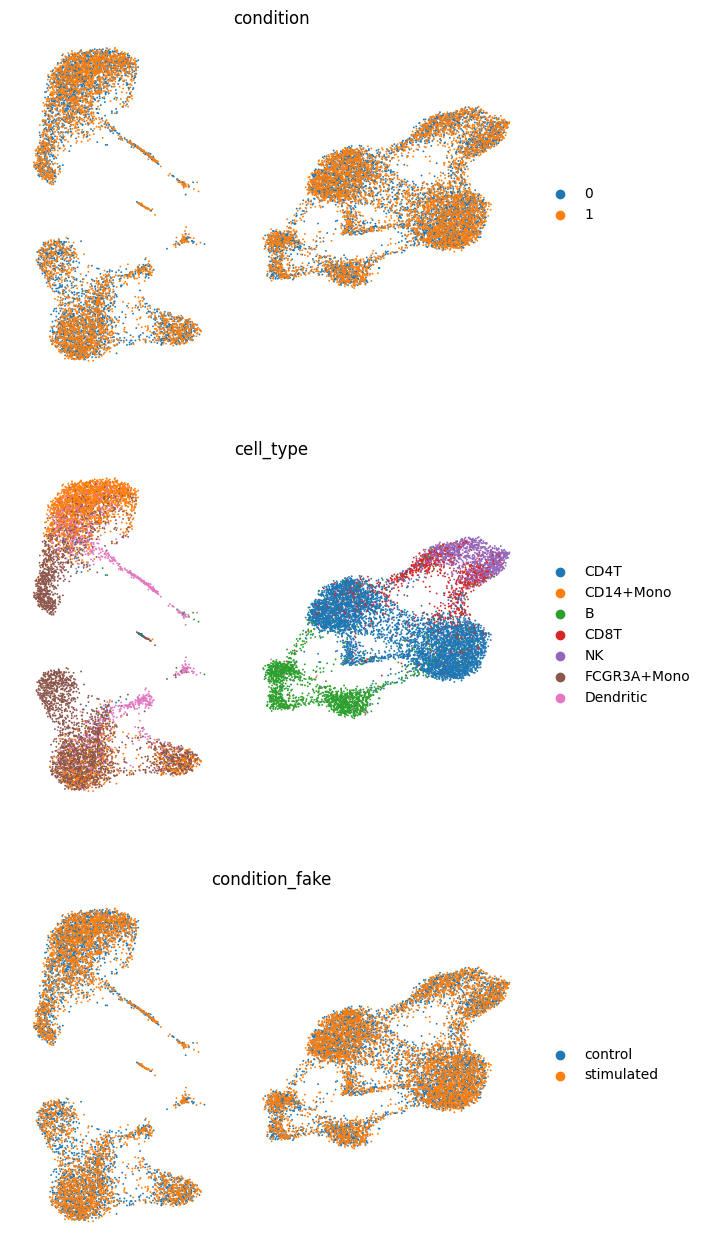

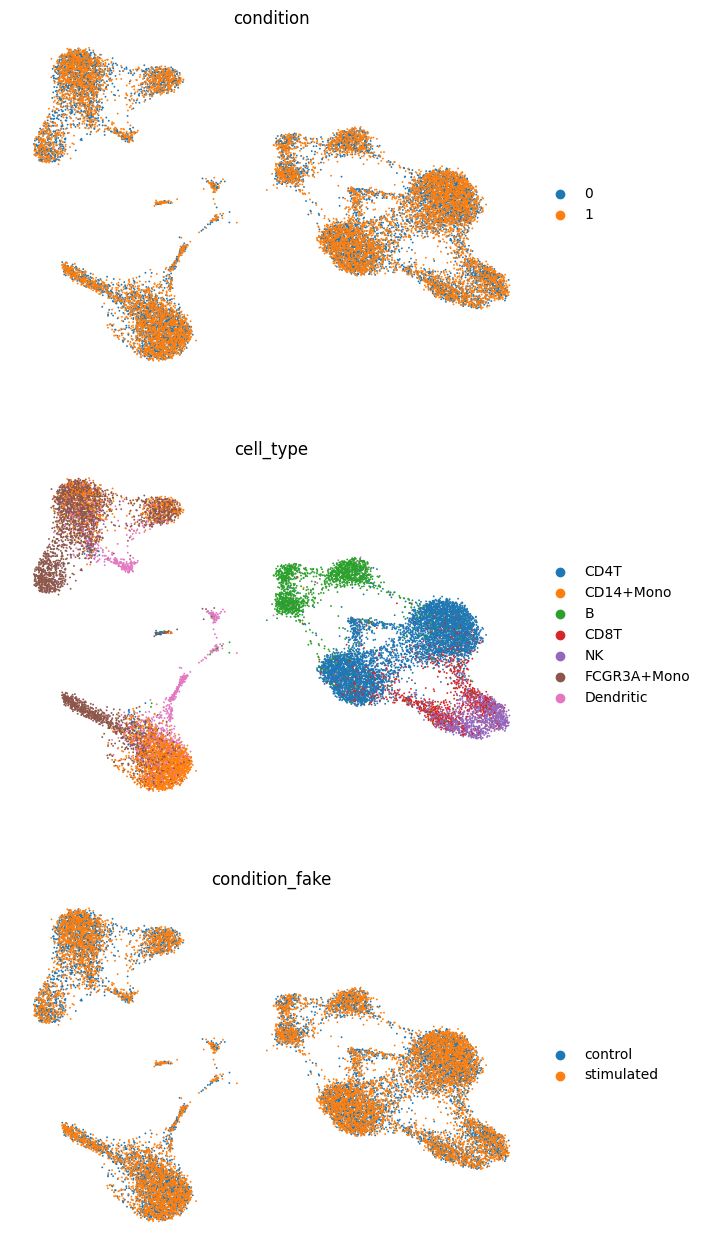

In [6]:
adata1=model.DL_model.adata.copy()

sc.pp.neighbors(adata1, use_rep='X_effect_modifier_space_PCA', n_neighbors=25)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=["condition",'cell_type',"condition_fake"], frameon=False, ncols=1)

sc.pp.neighbors(adata1, use_rep='X_effect_modifier_space', n_neighbors=25)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color=["condition",'cell_type',"condition_fake"], frameon=False, ncols=1)

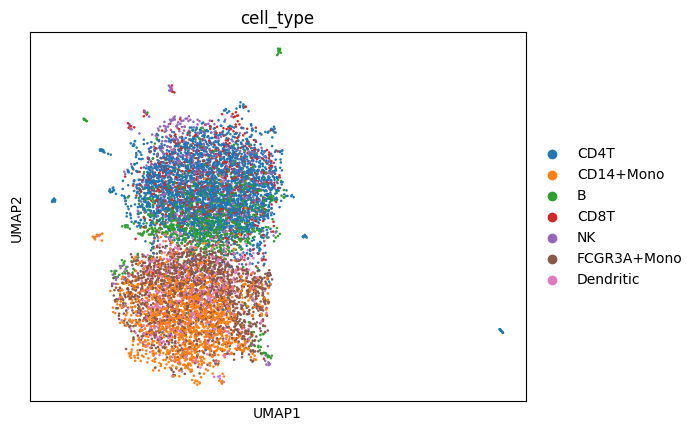

In [7]:
ITE1=sc.read_h5ad("./PBMC_fake_permute/b-0--c-1__ITE.h5ad")

sc.pp.pca(ITE1)
sc.pp.neighbors(ITE1)
sc.tl.umap(ITE1)
sc.pl.umap(ITE1, color=['cell_type'], ncols=1)

# Another way to estimate is to just use the control condition, and random assign condition to each cell

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/compat/__init__.py:358: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


(8007, 6998)


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


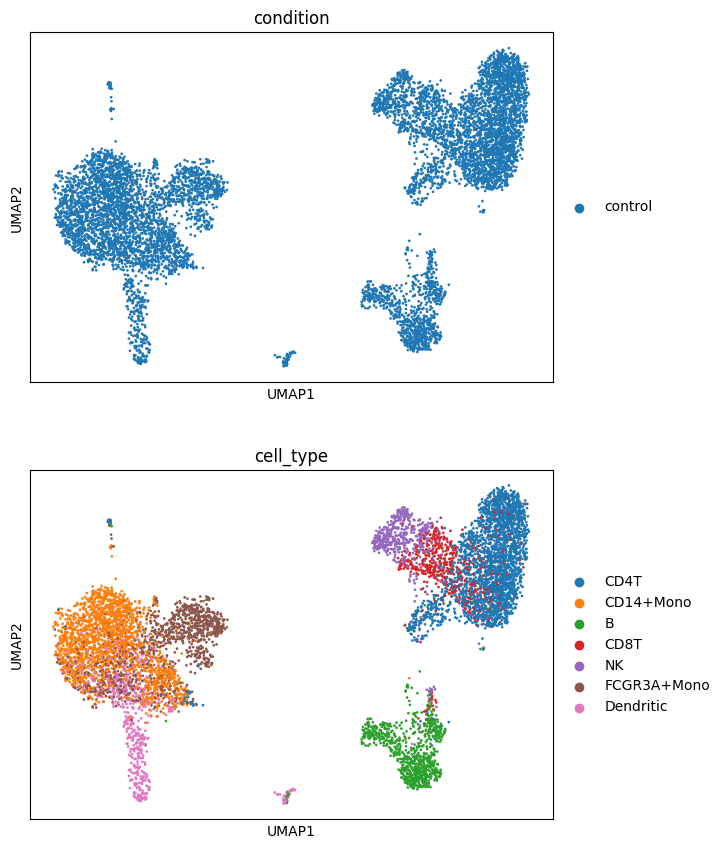

In [8]:
adata = sc.read_h5ad('../data/PBMC.h5ad')
adata2=adata[adata.obs["condition"]=="control"]
print(adata2.shape)
sc.pp.pca(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color=["condition",'cell_type'],ncols=1)

['0' '1']
['0' '1']


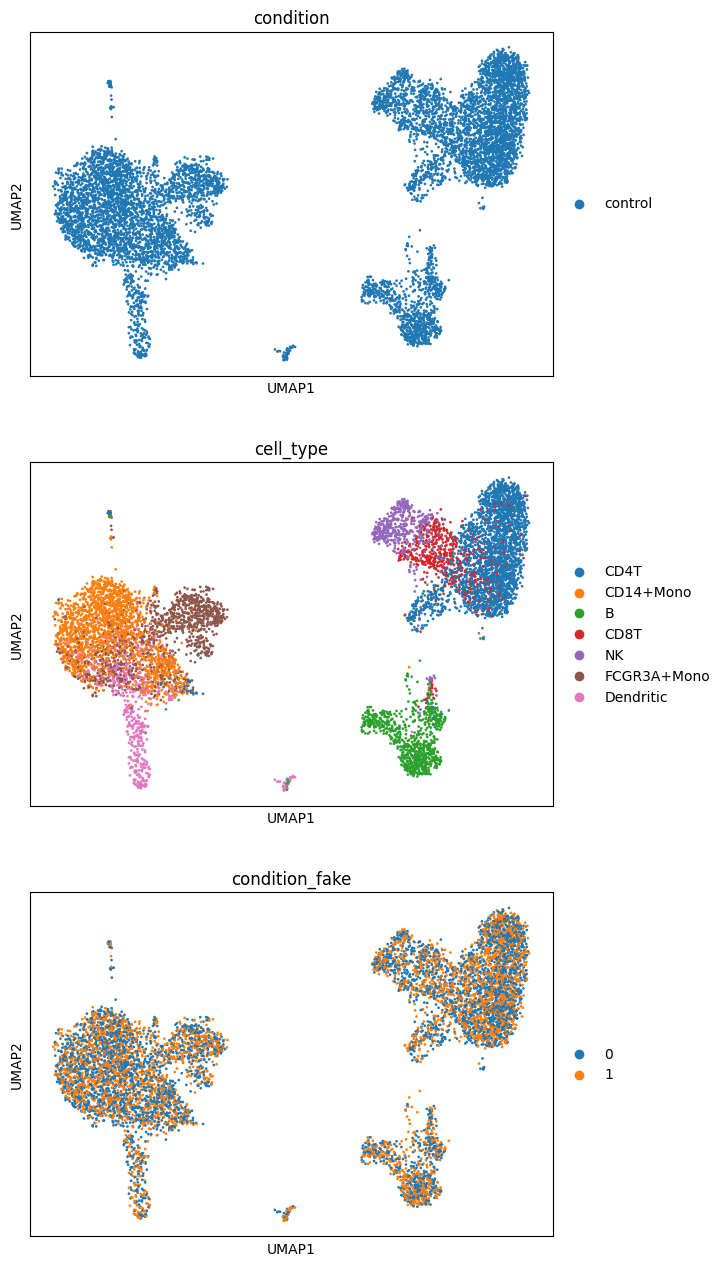

In [9]:
condition_fake=np.random.randint(0, 2, adata2.shape[0])
condition_fake=np.array([str(i) for i in condition_fake])
print(np.unique(condition_fake))
adata2.obs["condition_fake"]=condition_fake
print(np.unique(adata2.obs["condition_fake"]))
sc.pl.umap(adata2, color=["condition",'cell_type',"condition_fake"],ncols=1)

In [10]:
model = NDreamer(adata2, condition_key="condition_fake", contorl_name='0', num_hvg=2000, require_batch=False,
                        batch_key=None,
                        resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=100, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./PBMC_fake_random_part/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./PBMC_fake_random_part/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Start data preprocessing
Original adata.obs[condition_fake] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'0': 0, '1': 1}
Condition mapping to adata.obs['batch']: {'batch': {0: 0}}
Unique batch mapping: {0: 0}


Calculating the clusters
Unique groups: ['0_0' '0_1']


Finished clustering
Data preprocessing done
Remaining number of cells: 8007
Require batch: False
Batch name to number mapping (may be used for search for saved adata):
 {'batch': {0: 0}}
Condition name to number mapping (may be used for search for saved adata):
 {'0': 0, '1': 1}
Preprocessing time: 8.68321 seconds


/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ndreamer/single_cell_utils.py:100: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = clustered_adatas[0].concatenate(*clustered_adatas[1:], batch_key="batch_condition",


Overall Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | All Loss: 84.8986 | Neighborhood Loss: 14.0753 | Triplet Loss: 52.7445 | Reconstruction Loss: 15.9501 | Independent Loss: 11.2894 | KL Loss: 0.3606 | Commitment Loss: 0.5936 | Dependent Loss: -10.1149


Epoch: 2/100 | All Loss: 40.4626 | Neighborhood Loss: 14.2855 | Triplet Loss: 17.4782 | Reconstruction Loss: 10.0684 | Independent Loss: 8.9781 | KL Loss: 0.3926 | Commitment Loss: 0.5916 | Dependent Loss: -11.3319


Epoch: 3/100 | All Loss: 29.3286 | Neighborhood Loss: 15.4993 | Triplet Loss: 9.7637 | Reconstruction Loss: 7.7675 | Independent Loss: 7.3105 | KL Loss: 0.4531 | Commitment Loss: 0.5919 | Dependent Loss: -12.0575


Epoch: 4/100 | All Loss: 24.7818 | Neighborhood Loss: 14.8669 | Triplet Loss: 7.3100 | Reconstruction Loss: 7.6174 | Independent Loss: 6.5586 | KL Loss: 0.4655 | Commitment Loss: 0.5918 | Dependent Loss: -12.6282


Epoch: 5/100 | All Loss: 20.9382 | Neighborhood Loss: 14.4659 | Triplet Loss: 5.3317 | Reconstruction Loss: 7.4297 | Independent Loss: 5.4371 | KL Loss: 0.4500 | Commitment Loss: 0.5931 | Dependent Loss: -12.7694


Epoch: 6/100 | All Loss: 18.5404 | Neighborhood Loss: 13.3250 | Triplet Loss: 5.5145 | Reconstruction Loss: 7.2878 | Independent Loss: 4.4141 | KL Loss: 0.4218 | Commitment Loss: 0.5907 | Dependent Loss: -13.0134


Epoch: 7/100 | All Loss: 17.4685 | Neighborhood Loss: 12.8316 | Triplet Loss: 5.7106 | Reconstruction Loss: 7.1478 | Independent Loss: 4.0504 | KL Loss: 0.3854 | Commitment Loss: 0.5876 | Dependent Loss: -13.2450


Epoch: 8/100 | All Loss: 13.1728 | Neighborhood Loss: 11.8789 | Triplet Loss: 3.3992 | Reconstruction Loss: 7.0257 | Independent Loss: 3.3542 | KL Loss: 0.3519 | Commitment Loss: 0.5886 | Dependent Loss: -13.4256


Epoch: 9/100 | All Loss: 11.6896 | Neighborhood Loss: 11.1322 | Triplet Loss: 2.5775 | Reconstruction Loss: 7.0055 | Independent Loss: 3.5310 | KL Loss: 0.3175 | Commitment Loss: 0.5864 | Dependent Loss: -13.4605


Epoch: 10/100 | All Loss: 10.1085 | Neighborhood Loss: 10.8741 | Triplet Loss: 2.2261 | Reconstruction Loss: 6.6528 | Independent Loss: 3.1633 | KL Loss: 0.2918 | Commitment Loss: 0.5892 | Dependent Loss: -13.6888


Epoch: 11/100 | All Loss: 9.6122 | Neighborhood Loss: 10.2567 | Triplet Loss: 2.1685 | Reconstruction Loss: 6.9688 | Independent Loss: 3.2641 | KL Loss: 0.2617 | Commitment Loss: 0.5864 | Dependent Loss: -13.8939


Epoch: 12/100 | All Loss: 8.9888 | Neighborhood Loss: 9.5232 | Triplet Loss: 2.5014 | Reconstruction Loss: 6.7261 | Independent Loss: 3.2414 | KL Loss: 0.2436 | Commitment Loss: 0.5834 | Dependent Loss: -13.8303


Epoch: 13/100 | All Loss: 8.1875 | Neighborhood Loss: 9.3597 | Triplet Loss: 2.5103 | Reconstruction Loss: 6.6339 | Independent Loss: 2.7971 | KL Loss: 0.2262 | Commitment Loss: 0.5847 | Dependent Loss: -13.9245


Epoch: 14/100 | All Loss: 6.0883 | Neighborhood Loss: 8.3875 | Triplet Loss: 1.4340 | Reconstruction Loss: 6.6531 | Independent Loss: 2.8036 | KL Loss: 0.2106 | Commitment Loss: 0.5873 | Dependent Loss: -13.9878


Resetting 774 unused embeddings.
Resetting 732 unused embeddings.
Resetting 758 unused embeddings.


Resetting 715 unused embeddings.
Resetting 751 unused embeddings.
Resetting 761 unused embeddings.


Resetting 800 unused embeddings.
Resetting 735 unused embeddings.
Resetting 767 unused embeddings.


Resetting 757 unused embeddings.
Resetting 783 unused embeddings.
Resetting 733 unused embeddings.


Resetting 702 unused embeddings.
Resetting 746 unused embeddings.
Resetting 781 unused embeddings.


Resetting 812 unused embeddings.
Resetting 689 unused embeddings.
Resetting 787 unused embeddings.


Resetting 734 unused embeddings.
Resetting 747 unused embeddings.
Resetting 764 unused embeddings.


Resetting 794 unused embeddings.
Resetting 752 unused embeddings.
Resetting 784 unused embeddings.


Resetting 800 unused embeddings.
Resetting 764 unused embeddings.
Resetting 763 unused embeddings.


Resetting 766 unused embeddings.
Resetting 712 unused embeddings.
Resetting 742 unused embeddings.


Resetting 780 unused embeddings.
Resetting 749 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 14
Epoch: 15/100 | All Loss: 3.7774 | Neighborhood Loss: 4.7277 | Triplet Loss: 0.9633 | Reconstruction Loss: 3.2411 | Independent Loss: 1.4549 | KL Loss: 0.1007 | Commitment Loss: 0.2945 | Dependent Loss: -7.0049


Epoch: 16/100 | All Loss: 11.0656 | Neighborhood Loss: 10.2569 | Triplet Loss: 3.7159 | Reconstruction Loss: 6.6984 | Independent Loss: 1.4825 | KL Loss: 0.1759 | Commitment Loss: 0.2820 | Dependent Loss: -11.5460


Epoch: 17/100 | All Loss: 11.5052 | Neighborhood Loss: 10.0864 | Triplet Loss: 4.1296 | Reconstruction Loss: 6.7748 | Independent Loss: 1.5413 | KL Loss: 0.1608 | Commitment Loss: 0.2834 | Dependent Loss: -11.4712


Epoch: 18/100 | All Loss: 9.1446 | Neighborhood Loss: 9.1853 | Triplet Loss: 2.8047 | Reconstruction Loss: 6.6944 | Independent Loss: 1.4730 | KL Loss: 0.1495 | Commitment Loss: 0.2831 | Dependent Loss: -11.4454


Epoch: 19/100 | All Loss: 8.3835 | Neighborhood Loss: 8.6959 | Triplet Loss: 2.4403 | Reconstruction Loss: 6.5741 | Independent Loss: 1.6745 | KL Loss: 0.1413 | Commitment Loss: 0.2823 | Dependent Loss: -11.4250


Epoch: 20/100 | All Loss: 7.3100 | Neighborhood Loss: 7.9878 | Triplet Loss: 2.6658 | Reconstruction Loss: 6.5900 | Independent Loss: 1.2128 | KL Loss: 0.1360 | Commitment Loss: 0.2844 | Dependent Loss: -11.5669


Epoch: 21/100 | All Loss: 7.0315 | Neighborhood Loss: 8.2503 | Triplet Loss: 2.1622 | Reconstruction Loss: 6.6253 | Independent Loss: 1.2717 | KL Loss: 0.1294 | Commitment Loss: 0.2834 | Dependent Loss: -11.6907


Epoch: 22/100 | All Loss: 6.3186 | Neighborhood Loss: 7.7439 | Triplet Loss: 1.6667 | Reconstruction Loss: 6.4464 | Independent Loss: 1.7061 | KL Loss: 0.1254 | Commitment Loss: 0.2815 | Dependent Loss: -11.6513


Epoch: 23/100 | All Loss: 7.3440 | Neighborhood Loss: 7.7256 | Triplet Loss: 2.3531 | Reconstruction Loss: 6.5333 | Independent Loss: 2.0258 | KL Loss: 0.1181 | Commitment Loss: 0.2845 | Dependent Loss: -11.6965


Epoch: 24/100 | All Loss: 6.1125 | Neighborhood Loss: 7.4242 | Triplet Loss: 1.5446 | Reconstruction Loss: 6.5547 | Independent Loss: 1.8298 | KL Loss: 0.1143 | Commitment Loss: 0.2872 | Dependent Loss: -11.6425


Epoch: 25/100 | All Loss: 5.7702 | Neighborhood Loss: 7.2022 | Triplet Loss: 1.8209 | Reconstruction Loss: 6.5597 | Independent Loss: 1.5065 | KL Loss: 0.1096 | Commitment Loss: 0.2871 | Dependent Loss: -11.7157


Epoch: 26/100 | All Loss: 4.8974 | Neighborhood Loss: 7.6384 | Triplet Loss: 1.1011 | Reconstruction Loss: 6.4542 | Independent Loss: 1.1001 | KL Loss: 0.1068 | Commitment Loss: 0.2891 | Dependent Loss: -11.7925


Epoch: 27/100 | All Loss: 5.0681 | Neighborhood Loss: 7.2228 | Triplet Loss: 1.6721 | Reconstruction Loss: 6.4265 | Independent Loss: 1.2099 | KL Loss: 0.1029 | Commitment Loss: 0.2868 | Dependent Loss: -11.8529


Epoch: 28/100 | All Loss: 4.7903 | Neighborhood Loss: 6.9378 | Triplet Loss: 1.4581 | Reconstruction Loss: 6.4770 | Independent Loss: 1.3915 | KL Loss: 0.1001 | Commitment Loss: 0.2920 | Dependent Loss: -11.8662


Epoch: 29/100 | All Loss: 4.3397 | Neighborhood Loss: 6.9432 | Triplet Loss: 1.4175 | Reconstruction Loss: 6.3874 | Independent Loss: 1.2229 | KL Loss: 0.0994 | Commitment Loss: 0.2926 | Dependent Loss: -12.0232


Resetting 720 unused embeddings.
Resetting 716 unused embeddings.
Resetting 725 unused embeddings.


Resetting 713 unused embeddings.
Resetting 688 unused embeddings.
Resetting 740 unused embeddings.


Resetting 702 unused embeddings.
Resetting 703 unused embeddings.
Resetting 701 unused embeddings.


Resetting 726 unused embeddings.
Resetting 802 unused embeddings.
Resetting 716 unused embeddings.


Resetting 738 unused embeddings.
Resetting 718 unused embeddings.
Resetting 738 unused embeddings.


Resetting 716 unused embeddings.
Resetting 726 unused embeddings.
Resetting 761 unused embeddings.


Resetting 691 unused embeddings.
Resetting 692 unused embeddings.
Resetting 736 unused embeddings.


Resetting 752 unused embeddings.
Resetting 738 unused embeddings.
Resetting 745 unused embeddings.


Resetting 775 unused embeddings.
Resetting 717 unused embeddings.
Resetting 703 unused embeddings.


Resetting 731 unused embeddings.
Resetting 688 unused embeddings.
Resetting 697 unused embeddings.


Resetting 750 unused embeddings.
Resetting 721 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 29
Epoch: 30/100 | All Loss: 2.3921 | Neighborhood Loss: 3.0843 | Triplet Loss: 1.0004 | Reconstruction Loss: 3.2841 | Independent Loss: 0.7359 | KL Loss: 0.0484 | Commitment Loss: 0.1466 | Dependent Loss: -5.9076


Epoch: 31/100 | All Loss: 4.1268 | Neighborhood Loss: 6.9948 | Triplet Loss: 1.3741 | Reconstruction Loss: 6.5165 | Independent Loss: 1.1423 | KL Loss: 0.0934 | Commitment Loss: 0.2409 | Dependent Loss: -12.2351


Epoch: 32/100 | All Loss: 5.7245 | Neighborhood Loss: 7.4133 | Triplet Loss: 2.1741 | Reconstruction Loss: 6.4590 | Independent Loss: 1.4578 | KL Loss: 0.0928 | Commitment Loss: 0.2418 | Dependent Loss: -12.1143


Epoch: 33/100 | All Loss: 3.5940 | Neighborhood Loss: 6.3369 | Triplet Loss: 1.3580 | Reconstruction Loss: 6.4032 | Independent Loss: 1.3032 | KL Loss: 0.0902 | Commitment Loss: 0.2399 | Dependent Loss: -12.1374


Epoch: 34/100 | All Loss: 3.7809 | Neighborhood Loss: 6.3435 | Triplet Loss: 1.3495 | Reconstruction Loss: 6.4127 | Independent Loss: 1.5116 | KL Loss: 0.0883 | Commitment Loss: 0.2394 | Dependent Loss: -12.1642


Epoch: 35/100 | All Loss: 4.0435 | Neighborhood Loss: 6.3131 | Triplet Loss: 1.4189 | Reconstruction Loss: 6.4943 | Independent Loss: 1.7660 | KL Loss: 0.0869 | Commitment Loss: 0.2419 | Dependent Loss: -12.2776


Epoch: 36/100 | All Loss: 3.4467 | Neighborhood Loss: 6.1061 | Triplet Loss: 1.0429 | Reconstruction Loss: 6.4366 | Independent Loss: 1.7041 | KL Loss: 0.0872 | Commitment Loss: 0.2403 | Dependent Loss: -12.1705


Epoch: 37/100 | All Loss: 3.9594 | Neighborhood Loss: 6.2063 | Triplet Loss: 1.4700 | Reconstruction Loss: 6.4063 | Independent Loss: 1.8063 | KL Loss: 0.0887 | Commitment Loss: 0.2414 | Dependent Loss: -12.2596


Epoch: 38/100 | All Loss: 3.2321 | Neighborhood Loss: 6.2648 | Triplet Loss: 1.0542 | Reconstruction Loss: 6.3465 | Independent Loss: 1.5828 | KL Loss: 0.0889 | Commitment Loss: 0.2407 | Dependent Loss: -12.3456


Epoch: 39/100 | All Loss: 4.6010 | Neighborhood Loss: 6.4703 | Triplet Loss: 1.6291 | Reconstruction Loss: 6.4543 | Independent Loss: 1.9779 | KL Loss: 0.0857 | Commitment Loss: 0.2393 | Dependent Loss: -12.2555


Epoch: 40/100 | All Loss: 3.5955 | Neighborhood Loss: 6.5054 | Triplet Loss: 1.5101 | Reconstruction Loss: 6.4504 | Independent Loss: 1.1613 | KL Loss: 0.0843 | Commitment Loss: 0.2424 | Dependent Loss: -12.3584


Epoch: 41/100 | All Loss: 3.3541 | Neighborhood Loss: 5.8237 | Triplet Loss: 1.5467 | Reconstruction Loss: 6.3853 | Independent Loss: 1.6033 | KL Loss: 0.0820 | Commitment Loss: 0.2408 | Dependent Loss: -12.3278


Epoch: 42/100 | All Loss: 2.6352 | Neighborhood Loss: 6.2036 | Triplet Loss: 1.2851 | Reconstruction Loss: 6.3190 | Independent Loss: 1.0457 | KL Loss: 0.0805 | Commitment Loss: 0.2390 | Dependent Loss: -12.5378


Epoch: 43/100 | All Loss: 3.6441 | Neighborhood Loss: 6.2933 | Triplet Loss: 1.3667 | Reconstruction Loss: 6.4034 | Independent Loss: 1.7082 | KL Loss: 0.0797 | Commitment Loss: 0.2421 | Dependent Loss: -12.4494


Epoch: 44/100 | All Loss: 2.6676 | Neighborhood Loss: 5.6522 | Triplet Loss: 1.3359 | Reconstruction Loss: 6.4057 | Independent Loss: 1.4421 | KL Loss: 0.0794 | Commitment Loss: 0.2403 | Dependent Loss: -12.4880


Resetting 709 unused embeddings.
Resetting 694 unused embeddings.
Resetting 714 unused embeddings.


Resetting 679 unused embeddings.
Resetting 672 unused embeddings.
Resetting 683 unused embeddings.


Resetting 705 unused embeddings.
Resetting 684 unused embeddings.
Resetting 695 unused embeddings.


Resetting 690 unused embeddings.
Resetting 765 unused embeddings.
Resetting 694 unused embeddings.


Resetting 693 unused embeddings.
Resetting 679 unused embeddings.
Resetting 704 unused embeddings.


Resetting 709 unused embeddings.
Resetting 681 unused embeddings.
Resetting 719 unused embeddings.


Resetting 652 unused embeddings.
Resetting 676 unused embeddings.
Resetting 715 unused embeddings.


Resetting 714 unused embeddings.
Resetting 713 unused embeddings.
Resetting 722 unused embeddings.


Resetting 734 unused embeddings.
Resetting 708 unused embeddings.
Resetting 697 unused embeddings.


Resetting 690 unused embeddings.
Resetting 649 unused embeddings.
Resetting 688 unused embeddings.


Resetting 724 unused embeddings.
Resetting 685 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 44
Epoch: 45/100 | All Loss: 1.8541 | Neighborhood Loss: 3.1912 | Triplet Loss: 0.8216 | Reconstruction Loss: 3.2087 | Independent Loss: 0.7044 | KL Loss: 0.0396 | Commitment Loss: 0.1216 | Dependent Loss: -6.2328


Epoch: 46/100 | All Loss: 3.0992 | Neighborhood Loss: 5.7332 | Triplet Loss: 1.6132 | Reconstruction Loss: 6.2668 | Independent Loss: 1.7910 | KL Loss: 0.0801 | Commitment Loss: 0.2169 | Dependent Loss: -12.6020


Epoch: 47/100 | All Loss: 1.5423 | Neighborhood Loss: 5.5490 | Triplet Loss: 1.0495 | Reconstruction Loss: 6.4573 | Independent Loss: 1.0351 | KL Loss: 0.0790 | Commitment Loss: 0.2187 | Dependent Loss: -12.8465


Epoch: 48/100 | All Loss: 1.9655 | Neighborhood Loss: 5.6293 | Triplet Loss: 1.3164 | Reconstruction Loss: 6.2866 | Independent Loss: 1.2062 | KL Loss: 0.0810 | Commitment Loss: 0.2194 | Dependent Loss: -12.7735


Epoch: 49/100 | All Loss: 2.6262 | Neighborhood Loss: 5.8738 | Triplet Loss: 1.5265 | Reconstruction Loss: 6.3947 | Independent Loss: 1.3711 | KL Loss: 0.0821 | Commitment Loss: 0.2235 | Dependent Loss: -12.8454


Epoch: 50/100 | All Loss: 1.7186 | Neighborhood Loss: 5.5366 | Triplet Loss: 1.0309 | Reconstruction Loss: 6.3659 | Independent Loss: 1.3249 | KL Loss: 0.0819 | Commitment Loss: 0.2200 | Dependent Loss: -12.8416


Epoch: 51/100 | All Loss: 2.5711 | Neighborhood Loss: 5.8691 | Triplet Loss: 1.3672 | Reconstruction Loss: 6.4072 | Independent Loss: 1.4425 | KL Loss: 0.0800 | Commitment Loss: 0.2218 | Dependent Loss: -12.8167


Epoch: 52/100 | All Loss: 1.8115 | Neighborhood Loss: 5.4041 | Triplet Loss: 1.1436 | Reconstruction Loss: 6.4474 | Independent Loss: 1.3906 | KL Loss: 0.0784 | Commitment Loss: 0.2212 | Dependent Loss: -12.8738


Epoch: 53/100 | All Loss: 1.4673 | Neighborhood Loss: 5.2672 | Triplet Loss: 1.0357 | Reconstruction Loss: 6.1600 | Independent Loss: 1.5715 | KL Loss: 0.0792 | Commitment Loss: 0.2200 | Dependent Loss: -12.8663


Epoch: 54/100 | All Loss: 2.1301 | Neighborhood Loss: 5.6234 | Triplet Loss: 1.2399 | Reconstruction Loss: 6.2529 | Independent Loss: 1.6072 | KL Loss: 0.0796 | Commitment Loss: 0.2199 | Dependent Loss: -12.8928


Epoch: 55/100 | All Loss: 2.8471 | Neighborhood Loss: 5.6327 | Triplet Loss: 1.3037 | Reconstruction Loss: 6.4510 | Independent Loss: 2.1704 | KL Loss: 0.0781 | Commitment Loss: 0.2223 | Dependent Loss: -13.0111


Epoch: 56/100 | All Loss: 2.1316 | Neighborhood Loss: 5.7668 | Triplet Loss: 1.2445 | Reconstruction Loss: 6.4038 | Independent Loss: 1.4634 | KL Loss: 0.0770 | Commitment Loss: 0.2215 | Dependent Loss: -13.0454


Epoch: 57/100 | All Loss: 1.7735 | Neighborhood Loss: 5.6101 | Triplet Loss: 0.8390 | Reconstruction Loss: 6.2449 | Independent Loss: 1.7135 | KL Loss: 0.0759 | Commitment Loss: 0.2238 | Dependent Loss: -12.9336


Epoch: 58/100 | All Loss: 1.4526 | Neighborhood Loss: 5.2703 | Triplet Loss: 1.4554 | Reconstruction Loss: 6.4496 | Independent Loss: 1.0268 | KL Loss: 0.0739 | Commitment Loss: 0.2257 | Dependent Loss: -13.0491


Epoch: 59/100 | All Loss: 1.5935 | Neighborhood Loss: 5.4912 | Triplet Loss: 0.9805 | Reconstruction Loss: 6.3549 | Independent Loss: 1.5122 | KL Loss: 0.0751 | Commitment Loss: 0.2231 | Dependent Loss: -13.0435


Resetting 707 unused embeddings.
Resetting 691 unused embeddings.
Resetting 700 unused embeddings.


Resetting 686 unused embeddings.
Resetting 677 unused embeddings.


Resetting 670 unused embeddings.
Resetting 719 unused embeddings.


Resetting 683 unused embeddings.
Resetting 693 unused embeddings.
Resetting 697 unused embeddings.


Resetting 755 unused embeddings.
Resetting 688 unused embeddings.
Resetting 689 unused embeddings.


Resetting 668 unused embeddings.
Resetting 685 unused embeddings.
Resetting 714 unused embeddings.


Resetting 656 unused embeddings.
Resetting 707 unused embeddings.
Resetting 659 unused embeddings.
Resetting 675 unused embeddings.


Resetting 720 unused embeddings.
Resetting 730 unused embeddings.
Resetting 710 unused embeddings.


Resetting 722 unused embeddings.
Resetting 720 unused embeddings.
Resetting 709 unused embeddings.


Resetting 707 unused embeddings.
Resetting 685 unused embeddings.
Resetting 643 unused embeddings.


Resetting 691 unused embeddings.
Resetting 727 unused embeddings.
Resetting 678 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 59
Epoch: 60/100 | All Loss: 1.2688 | Neighborhood Loss: 2.7463 | Triplet Loss: 0.5987 | Reconstruction Loss: 3.1614 | Independent Loss: 1.0870 | KL Loss: 0.0375 | Commitment Loss: 0.1123 | Dependent Loss: -6.4745


Epoch: 61/100 | All Loss: 0.7228 | Neighborhood Loss: 5.4426 | Triplet Loss: 0.7510 | Reconstruction Loss: 6.3121 | Independent Loss: 1.2580 | KL Loss: 0.0766 | Commitment Loss: 0.2104 | Dependent Loss: -13.3279


Epoch: 62/100 | All Loss: 1.9111 | Neighborhood Loss: 5.4700 | Triplet Loss: 1.3408 | Reconstruction Loss: 6.4155 | Independent Loss: 1.7076 | KL Loss: 0.0754 | Commitment Loss: 0.2139 | Dependent Loss: -13.3122


Epoch: 63/100 | All Loss: 1.9450 | Neighborhood Loss: 5.2547 | Triplet Loss: 1.3645 | Reconstruction Loss: 6.4295 | Independent Loss: 1.9479 | KL Loss: 0.0743 | Commitment Loss: 0.2119 | Dependent Loss: -13.3378


Epoch: 64/100 | All Loss: 1.4870 | Neighborhood Loss: 5.5059 | Triplet Loss: 1.3625 | Reconstruction Loss: 6.3518 | Independent Loss: 1.3409 | KL Loss: 0.0747 | Commitment Loss: 0.2135 | Dependent Loss: -13.3623


Epoch: 65/100 | All Loss: 1.6901 | Neighborhood Loss: 5.4701 | Triplet Loss: 1.1163 | Reconstruction Loss: 6.4615 | Independent Loss: 1.7813 | KL Loss: 0.0736 | Commitment Loss: 0.2144 | Dependent Loss: -13.4271


Epoch: 66/100 | All Loss: 1.5956 | Neighborhood Loss: 5.6346 | Triplet Loss: 1.3048 | Reconstruction Loss: 6.3768 | Independent Loss: 1.4793 | KL Loss: 0.0737 | Commitment Loss: 0.2122 | Dependent Loss: -13.4858


Epoch: 67/100 | All Loss: 1.2502 | Neighborhood Loss: 5.3484 | Triplet Loss: 0.9382 | Reconstruction Loss: 6.3778 | Independent Loss: 1.6378 | KL Loss: 0.0720 | Commitment Loss: 0.2135 | Dependent Loss: -13.3374


Epoch: 68/100 | All Loss: 1.3934 | Neighborhood Loss: 5.3500 | Triplet Loss: 1.4131 | Reconstruction Loss: 6.3852 | Independent Loss: 1.4258 | KL Loss: 0.0713 | Commitment Loss: 0.2128 | Dependent Loss: -13.4648


Epoch: 69/100 | All Loss: 1.2548 | Neighborhood Loss: 5.4072 | Triplet Loss: 1.1265 | Reconstruction Loss: 6.2776 | Independent Loss: 1.6201 | KL Loss: 0.0735 | Commitment Loss: 0.2137 | Dependent Loss: -13.4638


Epoch: 70/100 | All Loss: 1.3271 | Neighborhood Loss: 5.4670 | Triplet Loss: 1.3140 | Reconstruction Loss: 6.2906 | Independent Loss: 1.3338 | KL Loss: 0.0762 | Commitment Loss: 0.2152 | Dependent Loss: -13.3697


Epoch: 71/100 | All Loss: 1.5146 | Neighborhood Loss: 5.4906 | Triplet Loss: 1.3999 | Reconstruction Loss: 6.4285 | Independent Loss: 1.5490 | KL Loss: 0.0760 | Commitment Loss: 0.2143 | Dependent Loss: -13.6437


Epoch: 72/100 | All Loss: 1.5255 | Neighborhood Loss: 5.6173 | Triplet Loss: 0.9354 | Reconstruction Loss: 6.3566 | Independent Loss: 1.8417 | KL Loss: 0.0782 | Commitment Loss: 0.2163 | Dependent Loss: -13.5199


Epoch: 73/100 | All Loss: 0.9783 | Neighborhood Loss: 5.7305 | Triplet Loss: 0.7089 | Reconstruction Loss: 6.2505 | Independent Loss: 1.5180 | KL Loss: 0.0794 | Commitment Loss: 0.2140 | Dependent Loss: -13.5230


Epoch: 74/100 | All Loss: 1.6483 | Neighborhood Loss: 5.4926 | Triplet Loss: 0.6241 | Reconstruction Loss: 6.3558 | Independent Loss: 2.3352 | KL Loss: 0.0774 | Commitment Loss: 0.2171 | Dependent Loss: -13.4539


Resetting 709 unused embeddings.
Resetting 696 unused embeddings.
Resetting 684 unused embeddings.
Resetting 683 unused embeddings.


Resetting 684 unused embeddings.
Resetting 676 unused embeddings.
Resetting 715 unused embeddings.
Resetting 691 unused embeddings.


Resetting 696 unused embeddings.
Resetting 693 unused embeddings.
Resetting 745 unused embeddings.


Resetting 704 unused embeddings.
Resetting 687 unused embeddings.
Resetting 679 unused embeddings.
Resetting 679 unused embeddings.


Resetting 717 unused embeddings.
Resetting 656 unused embeddings.
Resetting 696 unused embeddings.
Resetting 659 unused embeddings.


Resetting 672 unused embeddings.
Resetting 718 unused embeddings.
Resetting 735 unused embeddings.


Resetting 717 unused embeddings.
Resetting 723 unused embeddings.
Resetting 713 unused embeddings.


Resetting 704 unused embeddings.
Resetting 704 unused embeddings.
Resetting 683 unused embeddings.
Resetting 658 unused embeddings.


Resetting 692 unused embeddings.
Resetting 728 unused embeddings.
Resetting 687 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 74
Epoch: 75/100 | All Loss: 0.4059 | Neighborhood Loss: 2.6332 | Triplet Loss: 0.3968 | Reconstruction Loss: 3.2103 | Independent Loss: 0.8558 | KL Loss: 0.0375 | Commitment Loss: 0.1099 | Dependent Loss: -6.8376


Epoch: 76/100 | All Loss: 0.9637 | Neighborhood Loss: 5.0490 | Triplet Loss: 1.2481 | Reconstruction Loss: 6.3667 | Independent Loss: 1.5936 | KL Loss: 0.0741 | Commitment Loss: 0.2058 | Dependent Loss: -13.5736


Epoch: 77/100 | All Loss: 1.3812 | Neighborhood Loss: 5.3105 | Triplet Loss: 1.2467 | Reconstruction Loss: 6.3247 | Independent Loss: 1.8496 | KL Loss: 0.0744 | Commitment Loss: 0.2060 | Dependent Loss: -13.6308


Epoch: 78/100 | All Loss: 1.1383 | Neighborhood Loss: 5.4652 | Triplet Loss: 1.0267 | Reconstruction Loss: 6.4192 | Independent Loss: 1.6160 | KL Loss: 0.0744 | Commitment Loss: 0.2074 | Dependent Loss: -13.6707


Epoch: 79/100 | All Loss: 0.9789 | Neighborhood Loss: 5.4150 | Triplet Loss: 1.1286 | Reconstruction Loss: 6.4116 | Independent Loss: 1.4161 | KL Loss: 0.0737 | Commitment Loss: 0.2069 | Dependent Loss: -13.6731


Epoch: 80/100 | All Loss: 0.5413 | Neighborhood Loss: 5.2111 | Triplet Loss: 0.9092 | Reconstruction Loss: 6.3389 | Independent Loss: 1.6041 | KL Loss: 0.0741 | Commitment Loss: 0.2044 | Dependent Loss: -13.8003


Epoch: 81/100 | All Loss: 0.6428 | Neighborhood Loss: 5.3841 | Triplet Loss: 1.1963 | Reconstruction Loss: 6.3256 | Independent Loss: 1.1974 | KL Loss: 0.0751 | Commitment Loss: 0.2070 | Dependent Loss: -13.7427


Epoch: 82/100 | All Loss: 0.9314 | Neighborhood Loss: 5.1895 | Triplet Loss: 1.4424 | Reconstruction Loss: 6.3249 | Independent Loss: 1.5373 | KL Loss: 0.0754 | Commitment Loss: 0.2053 | Dependent Loss: -13.8434


Epoch: 83/100 | All Loss: 1.1091 | Neighborhood Loss: 5.3245 | Triplet Loss: 0.9532 | Reconstruction Loss: 6.2155 | Independent Loss: 2.0571 | KL Loss: 0.0751 | Commitment Loss: 0.2050 | Dependent Loss: -13.7213


Epoch: 84/100 | All Loss: 0.0020 | Neighborhood Loss: 5.2276 | Triplet Loss: 1.0251 | Reconstruction Loss: 6.1766 | Independent Loss: 1.2552 | KL Loss: 0.0737 | Commitment Loss: 0.2034 | Dependent Loss: -13.9596


Epoch: 85/100 | All Loss: 0.3993 | Neighborhood Loss: 5.4127 | Triplet Loss: 1.0824 | Reconstruction Loss: 6.3471 | Independent Loss: 1.1636 | KL Loss: 0.0708 | Commitment Loss: 0.2028 | Dependent Loss: -13.8801


Epoch: 86/100 | All Loss: 1.1460 | Neighborhood Loss: 5.3677 | Triplet Loss: 1.0152 | Reconstruction Loss: 6.2515 | Independent Loss: 1.9618 | KL Loss: 0.0700 | Commitment Loss: 0.2044 | Dependent Loss: -13.7246


Epoch: 87/100 | All Loss: 0.3962 | Neighborhood Loss: 5.2330 | Triplet Loss: 1.0845 | Reconstruction Loss: 6.3329 | Independent Loss: 1.3549 | KL Loss: 0.0688 | Commitment Loss: 0.2045 | Dependent Loss: -13.8824


Epoch: 88/100 | All Loss: 0.7242 | Neighborhood Loss: 5.0669 | Triplet Loss: 1.1604 | Reconstruction Loss: 6.3647 | Independent Loss: 1.6908 | KL Loss: 0.0691 | Commitment Loss: 0.2027 | Dependent Loss: -13.8304


Epoch: 89/100 | All Loss: -0.0544 | Neighborhood Loss: 5.1396 | Triplet Loss: 0.6625 | Reconstruction Loss: 6.4419 | Independent Loss: 1.1976 | KL Loss: 0.0710 | Commitment Loss: 0.2065 | Dependent Loss: -13.7734


Resetting 708 unused embeddings.
Resetting 699 unused embeddings.
Resetting 681 unused embeddings.


Resetting 699 unused embeddings.
Resetting 687 unused embeddings.
Resetting 680 unused embeddings.


Resetting 715 unused embeddings.
Resetting 695 unused embeddings.
Resetting 697 unused embeddings.


Resetting 701 unused embeddings.
Resetting 733 unused embeddings.
Resetting 703 unused embeddings.


Resetting 694 unused embeddings.
Resetting 686 unused embeddings.
Resetting 675 unused embeddings.


Resetting 722 unused embeddings.
Resetting 661 unused embeddings.
Resetting 689 unused embeddings.


Resetting 664 unused embeddings.
Resetting 679 unused embeddings.
Resetting 718 unused embeddings.


Resetting 741 unused embeddings.
Resetting 721 unused embeddings.
Resetting 722 unused embeddings.


Resetting 705 unused embeddings.
Resetting 699 unused embeddings.
Resetting 707 unused embeddings.


Resetting 685 unused embeddings.
Resetting 652 unused embeddings.
Resetting 698 unused embeddings.


Resetting 731 unused embeddings.
Resetting 692 unused embeddings.


Finish resetting codebook embeddings, current step (epoch): 89
Epoch: 90/100 | All Loss: 0.4297 | Neighborhood Loss: 2.7108 | Triplet Loss: 0.3324 | Reconstruction Loss: 3.1625 | Independent Loss: 0.9897 | KL Loss: 0.0365 | Commitment Loss: 0.1018 | Dependent Loss: -6.9039


Epoch: 91/100 | All Loss: 0.7476 | Neighborhood Loss: 5.5700 | Triplet Loss: 0.9219 | Reconstruction Loss: 6.3240 | Independent Loss: 1.7697 | KL Loss: 0.0742 | Commitment Loss: 0.1983 | Dependent Loss: -14.1105


Epoch: 92/100 | All Loss: 0.6425 | Neighborhood Loss: 5.0306 | Triplet Loss: 1.0579 | Reconstruction Loss: 6.3172 | Independent Loss: 1.8857 | KL Loss: 0.0745 | Commitment Loss: 0.1975 | Dependent Loss: -13.9209


Epoch: 93/100 | All Loss: 0.0601 | Neighborhood Loss: 5.3531 | Triplet Loss: 1.0692 | Reconstruction Loss: 6.3200 | Independent Loss: 1.1262 | KL Loss: 0.0746 | Commitment Loss: 0.1987 | Dependent Loss: -14.0816


Epoch: 94/100 | All Loss: 0.4754 | Neighborhood Loss: 5.4761 | Triplet Loss: 1.0251 | Reconstruction Loss: 6.1594 | Independent Loss: 1.6049 | KL Loss: 0.0771 | Commitment Loss: 0.1969 | Dependent Loss: -14.0641


Epoch: 95/100 | All Loss: 0.4459 | Neighborhood Loss: 5.3085 | Triplet Loss: 0.9841 | Reconstruction Loss: 6.3883 | Independent Loss: 1.5966 | KL Loss: 0.0784 | Commitment Loss: 0.1985 | Dependent Loss: -14.1085


Epoch: 96/100 | All Loss: -0.4331 | Neighborhood Loss: 5.2559 | Triplet Loss: 0.7183 | Reconstruction Loss: 6.2620 | Independent Loss: 1.2146 | KL Loss: 0.0802 | Commitment Loss: 0.1986 | Dependent Loss: -14.1627


Epoch: 97/100 | All Loss: 0.1518 | Neighborhood Loss: 5.5557 | Triplet Loss: 0.6354 | Reconstruction Loss: 6.3971 | Independent Loss: 1.4089 | KL Loss: 0.0787 | Commitment Loss: 0.1985 | Dependent Loss: -14.1227


Epoch: 98/100 | All Loss: 0.0029 | Neighborhood Loss: 5.4739 | Triplet Loss: 0.6786 | Reconstruction Loss: 6.2791 | Independent Loss: 1.4217 | KL Loss: 0.0770 | Commitment Loss: 0.1999 | Dependent Loss: -14.1273


Epoch: 99/100 | All Loss: 0.6674 | Neighborhood Loss: 5.3219 | Triplet Loss: 0.7923 | Reconstruction Loss: 6.3340 | Independent Loss: 2.1099 | KL Loss: 0.0736 | Commitment Loss: 0.1998 | Dependent Loss: -14.1642


Epoch: 100/100 | All Loss: 0.4599 | Neighborhood Loss: 5.1720 | Triplet Loss: 1.2586 | Reconstruction Loss: 6.3578 | Independent Loss: 1.6096 | KL Loss: 0.0706 | Commitment Loss: 0.1989 | Dependent Loss: -14.2076
Model training time: 1266.89876 seconds


Effect modifier space saved.
Model evaluating time: 21.71040 seconds
There is no batch in your dataset, return the expression
There is no batch in your dataset, return the expression


ITE evaluating: 0.91456 seconds


ITE evaluating: 0.94328 seconds


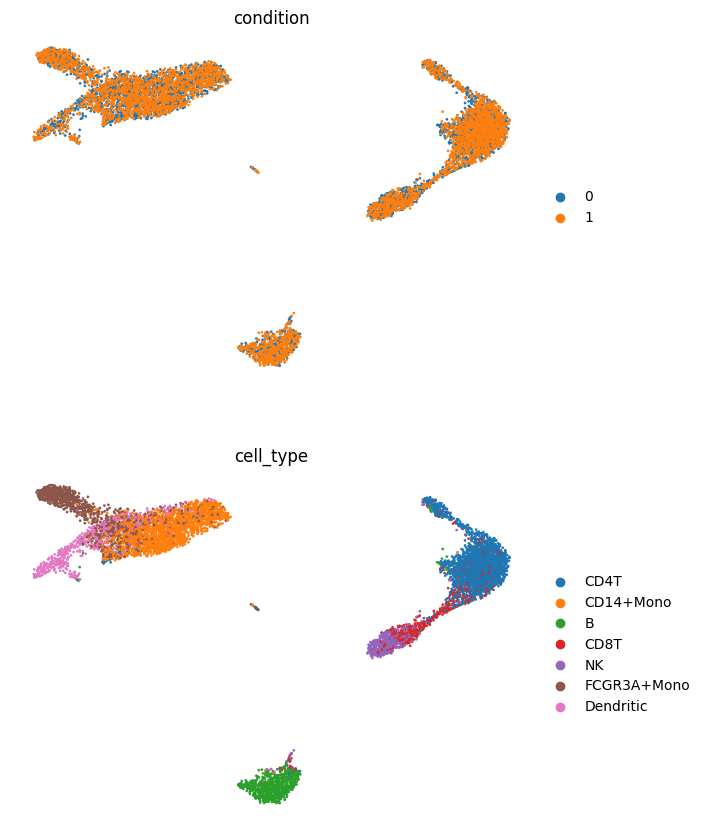

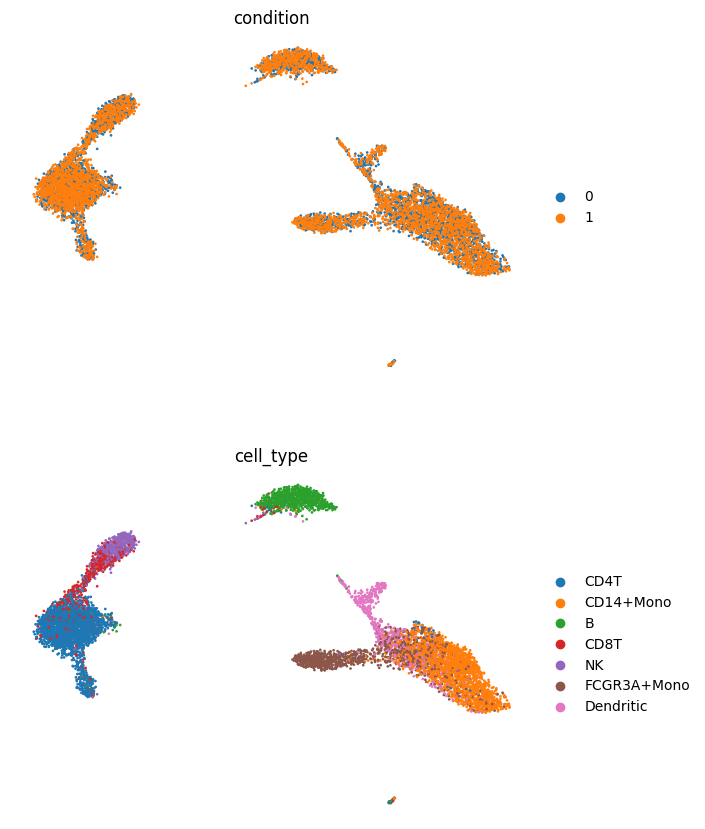

In [11]:
adata2=model.DL_model.adata.copy()

sc.pp.neighbors(adata2, use_rep='X_effect_modifier_space_PCA', n_neighbors=25)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color=['condition', 'cell_type'], frameon=False, ncols=1)

sc.pp.neighbors(adata2, use_rep='X_effect_modifier_space', n_neighbors=25)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color=['condition', 'cell_type'], frameon=False, ncols=1)

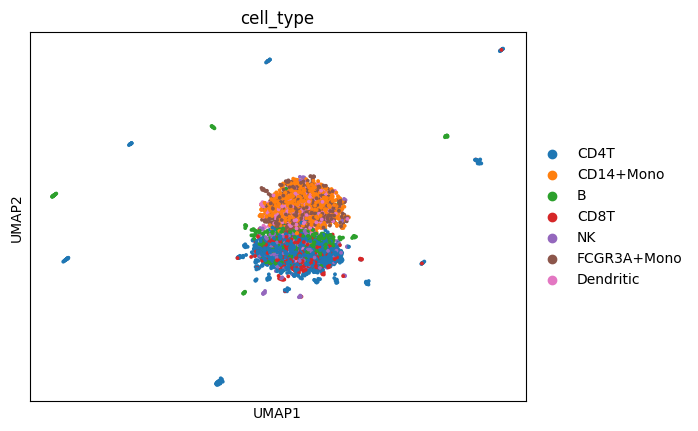

In [12]:
ITE2=sc.read_h5ad("./PBMC_fake_random_part/b-0--c-1__ITE.h5ad")

sc.pp.pca(ITE2)
sc.pp.neighbors(ITE2)
sc.tl.umap(ITE2)
sc.pl.umap(ITE2, color=['cell_type'], ncols=1)